# Data - Competition

## Imports e reads

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedShuffleSplit
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, BaggingClassifier, StackingClassifier

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

#!pip install xgboost
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.linear_model import LogisticRegression

import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout
from tensorflow.python.keras.losses import SparseCategoricalCrossentropy
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

In [2]:
df_meteo1 = pd.read_csv('datasets/meteo_202109-202112.csv', encoding='latin1')
df_meteo2 = pd.read_csv('datasets/meteo_202201-202212.csv', encoding='latin1')
df_meteo3 = pd.read_csv('datasets/meteo_202301-202304.csv', encoding='latin1')
df_energia1 = pd.read_csv('datasets/energia_202109-202112.csv', encoding='latin1')
df_energia2 = pd.read_csv('datasets/energia_202201-202212.csv', encoding='latin1')
df_energia3 = pd.read_csv('datasets/energia_202301-202304.csv', encoding='latin1') # Temos que prever os valores da energia injetada neste dataset
df_open = pd.read_csv('datasets/open-meteo-41.58N8.44W193m_1.csv', delimiter=',') # dataset de 2021 e 2022
df_open2 = pd.read_csv('datasets/open-meteo-41.58N8.44W193m_2.csv', delimiter=',') # dataset de 2023
df_open3 = pd.read_csv('datasets/open-meteo-41.58N8.44W193m_3.csv', delimiter=',') # dataset de 2023 para substituir no df_meteo3
df_open4 = pd.read_csv('datasets/open-meteo-41.58N8.44W193m_4.csv', delimiter=',') # dataset de 2023 para substituir no df_meteo3 (variaveis daily)
df_submission = pd.read_csv('datasets/dummy_submission.csv')

## Tratamento dos dados

### Tratamento dos dados de 2021

In [3]:
df_energia1.rename(columns={'Data': 'date', 'Hora': 'hour'}, inplace=True)
df_energia1

,date,hour,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),Injeção na rede (kWh)
0,2021-09-29,0,0.000,0.000,0.0,NaN
1,2021-09-29,1,0.000,0.000,0.0,NaN
2,2021-09-29,2,0.000,0.000,0.0,NaN
3,2021-09-29,3,0.000,0.000,0.0,NaN
4,2021-09-29,4,0.000,0.000,0.0,NaN
...,...,...,...,...,...,...
2251,2021-12-31,19,2.176,0.000,0.0,NaN
2252,2021-12-31,20,0.732,0.000,0.0,NaN
2253,2021-12-31,21,0.704,0.000,0.0,NaN
2254,2021-12-31,22,0.000,0.424,0.0,NaN


In [4]:
df_meteo1

,dt,dt_iso,city_name,temp,feels_like,temp_min,temp_max,pressure,sea_level,grnd_level,humidity,wind_speed,rain_1h,clouds_all,weather_description
0,1630454400,2021-09-01 00:00:00 +0000 UTC,local,18.74,18.84,15.72,20.34,1015,NaN,NaN,83,1.18,NaN,78,broken clouds
1,1630458000,2021-09-01 01:00:00 +0000 UTC,local,18.73,18.83,15.72,20.34,1014,NaN,NaN,83,1.46,NaN,92,overcast clouds
2,1630461600,2021-09-01 02:00:00 +0000 UTC,local,17.84,17.98,16.72,20.34,1014,NaN,NaN,88,1.05,NaN,91,overcast clouds
3,1630465200,2021-09-01 03:00:00 +0000 UTC,local,18.27,18.40,16.68,20.34,1014,NaN,NaN,86,0.46,0.14,94,light rain
4,1630468800,2021-09-01 04:00:00 +0000 UTC,local,17.81,17.97,16.12,20.34,1013,NaN,NaN,89,0.93,1.26,95,moderate rain
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2923,1640977200,2021-12-31 19:00:00 +0000 UTC,local,16.72,16.35,16.22,17.79,1024,NaN,NaN,73,3.05,NaN,91,overcast clouds
2924,1640980800,2021-12-31 20:00:00 +0000 UTC,local,16.54,16.10,15.67,17.23,1024,NaN,NaN,71,3.32,NaN,97,overcast clouds
2925,1640984400,2021-12-31 21:00:00 +0000 UTC,local,15.71,15.09,15.66,16.22,1023,NaN,NaN,67,3.43,NaN,94,overcast clouds
2926,1640988000,2021-12-31 22:00:00 +0000 UTC,local,16.59,15.98,16.21,16.72,1024,NaN,NaN,64,3.29,NaN,83,broken clouds


In [5]:
# Converter a coluna 'dt_iso' para datetime
df_meteo1['dt_iso'] = pd.to_datetime(df_meteo1['dt_iso'], format='%Y-%m-%d %H:%M:%S %z UTC')

# Criar novas colunas 'date' e 'hour'
df_meteo1['date'] = df_meteo1['dt_iso'].dt.strftime('%Y-%m-%d')
df_meteo1['hour'] = df_meteo1['dt_iso'].dt.hour

# Reordenar as colunas
df_meteo1 = df_meteo1[['date', 'hour'] + [col for col in df_meteo1.columns if col not in ['dt_iso', 'date', 'hour']]]

# Exibir o DataFrame resultante
df_meteo1

,date,hour,dt,city_name,temp,feels_like,temp_min,temp_max,pressure,sea_level,grnd_level,humidity,wind_speed,rain_1h,clouds_all,weather_description
0,2021-09-01,0,1630454400,local,18.74,18.84,15.72,20.34,1015,NaN,NaN,83,1.18,NaN,78,broken clouds
1,2021-09-01,1,1630458000,local,18.73,18.83,15.72,20.34,1014,NaN,NaN,83,1.46,NaN,92,overcast clouds
2,2021-09-01,2,1630461600,local,17.84,17.98,16.72,20.34,1014,NaN,NaN,88,1.05,NaN,91,overcast clouds
3,2021-09-01,3,1630465200,local,18.27,18.40,16.68,20.34,1014,NaN,NaN,86,0.46,0.14,94,light rain
4,2021-09-01,4,1630468800,local,17.81,17.97,16.12,20.34,1013,NaN,NaN,89,0.93,1.26,95,moderate rain
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2923,2021-12-31,19,1640977200,local,16.72,16.35,16.22,17.79,1024,NaN,NaN,73,3.05,NaN,91,overcast clouds
2924,2021-12-31,20,1640980800,local,16.54,16.10,15.67,17.23,1024,NaN,NaN,71,3.32,NaN,97,overcast clouds
2925,2021-12-31,21,1640984400,local,15.71,15.09,15.66,16.22,1023,NaN,NaN,67,3.43,NaN,94,overcast clouds
2926,2021-12-31,22,1640988000,local,16.59,15.98,16.21,16.72,1024,NaN,NaN,64,3.29,NaN,83,broken clouds


In [6]:
# Supondo que 'date' e 'hour' sejam colunas em ambos os DataFrames
df1 = pd.merge(df_meteo1, df_energia1, on=['date', 'hour'], how='inner')

# Exibir o DataFrame resultante
df1

,date,hour,dt,city_name,temp,feels_like,temp_min,temp_max,pressure,sea_level,grnd_level,humidity,wind_speed,rain_1h,clouds_all,weather_description,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),Injeção na rede (kWh)
0,2021-09-29,0,1632873600,local,13.97,13.54,11.45,14.04,1027,NaN,NaN,81,1.96,NaN,87,overcast clouds,0.000,0.000,0.0,NaN
1,2021-09-29,1,1632877200,local,13.48,13.02,13.43,13.90,1028,NaN,NaN,82,1.83,NaN,91,overcast clouds,0.000,0.000,0.0,NaN
2,2021-09-29,2,1632880800,local,12.93,12.47,12.72,13.43,1027,NaN,NaN,84,1.96,NaN,93,overcast clouds,0.000,0.000,0.0,NaN
3,2021-09-29,3,1632884400,local,12.61,12.15,10.34,12.93,1027,NaN,NaN,85,1.85,NaN,95,overcast clouds,0.000,0.000,0.0,NaN
4,2021-09-29,4,1632888000,local,12.61,12.17,9.79,12.93,1027,NaN,NaN,86,1.83,NaN,93,overcast clouds,0.000,0.000,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2251,2021-12-31,19,1640977200,local,16.72,16.35,16.22,17.79,1024,NaN,NaN,73,3.05,NaN,91,overcast clouds,2.176,0.000,0.0,NaN
2252,2021-12-31,20,1640980800,local,16.54,16.10,15.67,17.23,1024,NaN,NaN,71,3.32,NaN,97,overcast clouds,0.732,0.000,0.0,NaN
2253,2021-12-31,21,1640984400,local,15.71,15.09,15.66,16.22,1023,NaN,NaN,67,3.43,NaN,94,overcast clouds,0.704,0.000,0.0,NaN
2254,2021-12-31,22,1640988000,local,16.59,15.98,16.21,16.72,1024,NaN,NaN,64,3.29,NaN,83,broken clouds,0.000,0.424,0.0,NaN


<Axes: >

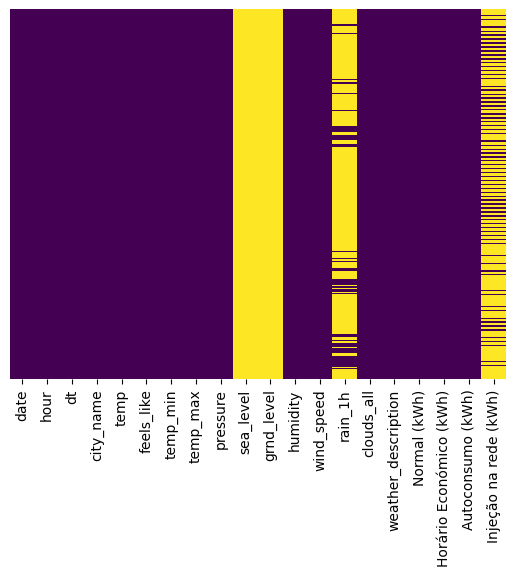

In [7]:
sns.heatmap(df1.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [8]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2256 entries, 0 to 2255
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   date                     2256 non-null   object 
 1   hour                     2256 non-null   int32  
 2   dt                       2256 non-null   int64  
 3   city_name                2256 non-null   object 
 4   temp                     2256 non-null   float64
 5   feels_like               2256 non-null   float64
 6   temp_min                 2256 non-null   float64
 7   temp_max                 2256 non-null   float64
 8   pressure                 2256 non-null   int64  
 9   sea_level                0 non-null      float64
 10  grnd_level               0 non-null      float64
 11  humidity                 2256 non-null   int64  
 12  wind_speed               2256 non-null   float64
 13  rain_1h                  386 non-null    float64
 14  clouds_all              

In [9]:
df1 = df1.drop(['city_name', 'sea_level', 'grnd_level'], axis=1)
df1

,date,hour,dt,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,rain_1h,clouds_all,weather_description,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),Injeção na rede (kWh)
0,2021-09-29,0,1632873600,13.97,13.54,11.45,14.04,1027,81,1.96,NaN,87,overcast clouds,0.000,0.000,0.0,NaN
1,2021-09-29,1,1632877200,13.48,13.02,13.43,13.90,1028,82,1.83,NaN,91,overcast clouds,0.000,0.000,0.0,NaN
2,2021-09-29,2,1632880800,12.93,12.47,12.72,13.43,1027,84,1.96,NaN,93,overcast clouds,0.000,0.000,0.0,NaN
3,2021-09-29,3,1632884400,12.61,12.15,10.34,12.93,1027,85,1.85,NaN,95,overcast clouds,0.000,0.000,0.0,NaN
4,2021-09-29,4,1632888000,12.61,12.17,9.79,12.93,1027,86,1.83,NaN,93,overcast clouds,0.000,0.000,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2251,2021-12-31,19,1640977200,16.72,16.35,16.22,17.79,1024,73,3.05,NaN,91,overcast clouds,2.176,0.000,0.0,NaN
2252,2021-12-31,20,1640980800,16.54,16.10,15.67,17.23,1024,71,3.32,NaN,97,overcast clouds,0.732,0.000,0.0,NaN
2253,2021-12-31,21,1640984400,15.71,15.09,15.66,16.22,1023,67,3.43,NaN,94,overcast clouds,0.704,0.000,0.0,NaN
2254,2021-12-31,22,1640988000,16.59,15.98,16.21,16.72,1024,64,3.29,NaN,83,broken clouds,0.000,0.424,0.0,NaN


In [10]:
# Contagem de valores nulos em cada coluna
print(df1.isnull().sum())

date                          0
hour                          0
dt                            0
temp                          0
feels_like                    0
temp_min                      0
temp_max                      0
pressure                      0
humidity                      0
wind_speed                    0
rain_1h                    1870
clouds_all                    0
weather_description           0
Normal (kWh)                  0
Horário Económico (kWh)       0
Autoconsumo (kWh)             0
Injeção na rede (kWh)      1690
dtype: int64


In [11]:
# Contagem de valores únicos em cada coluna
print(df1.nunique())

date                         94
hour                         24
dt                         2256
temp                       1023
feels_like                 1214
temp_min                    245
temp_max                    229
pressure                     35
humidity                     68
wind_speed                  554
rain_1h                     149
clouds_all                  101
weather_description           8
Normal (kWh)                772
Horário Económico (kWh)     329
Autoconsumo (kWh)           440
Injeção na rede (kWh)         4
dtype: int64


In [12]:
# Verificar a presença de valores NaN no DataFrame
print(df1.isna().values.any())

True


In [13]:
df1['date'] = pd.to_datetime(df1['date'], format='%Y-%m-%d')

In [14]:
df1['Injeção na rede (kWh)'].replace({None: 'None', np.nan: 'None'}, inplace=True)
df1['rain_1h'].fillna(0, inplace=True)
df1

,date,hour,dt,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,rain_1h,clouds_all,weather_description,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),Injeção na rede (kWh)
0,2021-09-29,0,1632873600,13.97,13.54,11.45,14.04,1027,81,1.96,0.0,87,overcast clouds,0.000,0.000,0.0,None
1,2021-09-29,1,1632877200,13.48,13.02,13.43,13.90,1028,82,1.83,0.0,91,overcast clouds,0.000,0.000,0.0,None
2,2021-09-29,2,1632880800,12.93,12.47,12.72,13.43,1027,84,1.96,0.0,93,overcast clouds,0.000,0.000,0.0,None
3,2021-09-29,3,1632884400,12.61,12.15,10.34,12.93,1027,85,1.85,0.0,95,overcast clouds,0.000,0.000,0.0,None
4,2021-09-29,4,1632888000,12.61,12.17,9.79,12.93,1027,86,1.83,0.0,93,overcast clouds,0.000,0.000,0.0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2251,2021-12-31,19,1640977200,16.72,16.35,16.22,17.79,1024,73,3.05,0.0,91,overcast clouds,2.176,0.000,0.0,None
2252,2021-12-31,20,1640980800,16.54,16.10,15.67,17.23,1024,71,3.32,0.0,97,overcast clouds,0.732,0.000,0.0,None
2253,2021-12-31,21,1640984400,15.71,15.09,15.66,16.22,1023,67,3.43,0.0,94,overcast clouds,0.704,0.000,0.0,None
2254,2021-12-31,22,1640988000,16.59,15.98,16.21,16.72,1024,64,3.29,0.0,83,broken clouds,0.000,0.424,0.0,None


In [15]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2256 entries, 0 to 2255
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   date                     2256 non-null   datetime64[ns]
 1   hour                     2256 non-null   int32         
 2   dt                       2256 non-null   int64         
 3   temp                     2256 non-null   float64       
 4   feels_like               2256 non-null   float64       
 5   temp_min                 2256 non-null   float64       
 6   temp_max                 2256 non-null   float64       
 7   pressure                 2256 non-null   int64         
 8   humidity                 2256 non-null   int64         
 9   wind_speed               2256 non-null   float64       
 10  rain_1h                  2256 non-null   float64       
 11  clouds_all               2256 non-null   int64         
 12  weather_description      2256 non-

<Axes: >

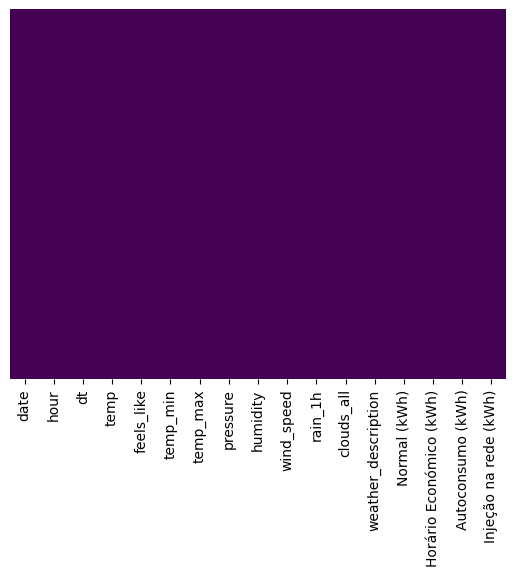

In [16]:
sns.heatmap(df1.isnull(),yticklabels=False,cbar=False,cmap='viridis')

### Tratamento dos dados de 2022

In [17]:
df_energia2.rename(columns={'Data': 'date', 'Hora': 'hour'}, inplace=True)
df_energia2

,date,hour,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),Injeção na rede (kWh)
0,2022-01-01,0,0.000,0.486,0.0,NaN
1,2022-01-01,1,0.000,0.429,0.0,NaN
2,2022-01-01,2,0.000,0.463,0.0,NaN
3,2022-01-01,3,0.000,0.545,0.0,NaN
4,2022-01-01,4,0.000,0.439,0.0,NaN
...,...,...,...,...,...,...
8755,2022-12-31,19,1.693,0.000,0.0,NaN
8756,2022-12-31,20,1.327,0.000,0.0,NaN
8757,2022-12-31,21,0.757,0.000,0.0,NaN
8758,2022-12-31,22,0.000,0.675,0.0,NaN


In [18]:
df_meteo2

,dt,dt_iso,city_name,temp,feels_like,temp_min,temp_max,pressure,sea_level,grnd_level,humidity,wind_speed,rain_1h,clouds_all,weather_description
0,1640995200,2022-01-01 00:00:00 +0000 UTC,local,16.59,16.00,16.21,16.72,1024,NaN,NaN,65,3.15,NaN,97,overcast clouds
1,1640998800,2022-01-01 01:00:00 +0000 UTC,local,16.59,16.00,16.21,16.72,1024,NaN,NaN,65,3.14,NaN,58,broken clouds
2,1641002400,2022-01-01 02:00:00 +0000 UTC,local,16.59,16.03,15.67,16.72,1024,NaN,NaN,66,3.12,NaN,23,few clouds
3,1641006000,2022-01-01 03:00:00 +0000 UTC,local,13.59,12.75,11.61,16.16,1023,NaN,NaN,67,3.08,NaN,22,few clouds
4,1641009600,2022-01-01 04:00:00 +0000 UTC,local,14.97,14.27,14.72,15.66,1023,NaN,NaN,67,3.12,NaN,15,few clouds
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,1672513200,2022-12-31 19:00:00 +0000 UTC,local,15.70,15.57,15.57,15.72,1018,NaN,NaN,86,5.56,3.58,100,moderate rain
8756,1672516800,2022-12-31 20:00:00 +0000 UTC,local,15.55,15.43,12.72,15.70,1018,NaN,NaN,87,4.47,4.20,100,heavy intensity rain
8757,1672520400,2022-12-31 21:00:00 +0000 UTC,local,13.45,13.28,12.23,13.99,1019,NaN,NaN,93,3.29,4.23,100,heavy intensity rain
8758,1672524000,2022-12-31 22:00:00 +0000 UTC,local,12.93,12.73,12.23,13.43,1019,NaN,NaN,94,1.49,3.90,100,moderate rain


In [19]:
# Converter a coluna 'dt_iso' para datetime
df_meteo2['dt_iso'] = pd.to_datetime(df_meteo2['dt_iso'], format='%Y-%m-%d %H:%M:%S %z UTC')

# Criar novas colunas 'date' e 'hour'
df_meteo2['date'] = df_meteo2['dt_iso'].dt.strftime('%Y-%m-%d')
df_meteo2['hour'] = df_meteo2['dt_iso'].dt.hour

# Reordenar as colunas
df_meteo2 = df_meteo2[['date', 'hour'] + [col for col in df_meteo2.columns if col not in ['dt_iso', 'date', 'hour']]]

# Exibir o DataFrame resultante
df_meteo2

,date,hour,dt,city_name,temp,feels_like,temp_min,temp_max,pressure,sea_level,grnd_level,humidity,wind_speed,rain_1h,clouds_all,weather_description
0,2022-01-01,0,1640995200,local,16.59,16.00,16.21,16.72,1024,NaN,NaN,65,3.15,NaN,97,overcast clouds
1,2022-01-01,1,1640998800,local,16.59,16.00,16.21,16.72,1024,NaN,NaN,65,3.14,NaN,58,broken clouds
2,2022-01-01,2,1641002400,local,16.59,16.03,15.67,16.72,1024,NaN,NaN,66,3.12,NaN,23,few clouds
3,2022-01-01,3,1641006000,local,13.59,12.75,11.61,16.16,1023,NaN,NaN,67,3.08,NaN,22,few clouds
4,2022-01-01,4,1641009600,local,14.97,14.27,14.72,15.66,1023,NaN,NaN,67,3.12,NaN,15,few clouds
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2022-12-31,19,1672513200,local,15.70,15.57,15.57,15.72,1018,NaN,NaN,86,5.56,3.58,100,moderate rain
8756,2022-12-31,20,1672516800,local,15.55,15.43,12.72,15.70,1018,NaN,NaN,87,4.47,4.20,100,heavy intensity rain
8757,2022-12-31,21,1672520400,local,13.45,13.28,12.23,13.99,1019,NaN,NaN,93,3.29,4.23,100,heavy intensity rain
8758,2022-12-31,22,1672524000,local,12.93,12.73,12.23,13.43,1019,NaN,NaN,94,1.49,3.90,100,moderate rain


In [20]:
# Supondo que 'date' e 'hour' sejam colunas em ambos os DataFrames
df2 = pd.merge(df_meteo2, df_energia2, on=['date', 'hour'], how='inner')

# Exibir o DataFrame resultante
df2

,date,hour,dt,city_name,temp,feels_like,temp_min,temp_max,pressure,sea_level,grnd_level,humidity,wind_speed,rain_1h,clouds_all,weather_description,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),Injeção na rede (kWh)
0,2022-01-01,0,1640995200,local,16.59,16.00,16.21,16.72,1024,NaN,NaN,65,3.15,NaN,97,overcast clouds,0.000,0.486,0.0,NaN
1,2022-01-01,1,1640998800,local,16.59,16.00,16.21,16.72,1024,NaN,NaN,65,3.14,NaN,58,broken clouds,0.000,0.429,0.0,NaN
2,2022-01-01,2,1641002400,local,16.59,16.03,15.67,16.72,1024,NaN,NaN,66,3.12,NaN,23,few clouds,0.000,0.463,0.0,NaN
3,2022-01-01,3,1641006000,local,13.59,12.75,11.61,16.16,1023,NaN,NaN,67,3.08,NaN,22,few clouds,0.000,0.545,0.0,NaN
4,2022-01-01,4,1641009600,local,14.97,14.27,14.72,15.66,1023,NaN,NaN,67,3.12,NaN,15,few clouds,0.000,0.439,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2022-12-31,19,1672513200,local,15.70,15.57,15.57,15.72,1018,NaN,NaN,86,5.56,3.58,100,moderate rain,1.693,0.000,0.0,NaN
8756,2022-12-31,20,1672516800,local,15.55,15.43,12.72,15.70,1018,NaN,NaN,87,4.47,4.20,100,heavy intensity rain,1.327,0.000,0.0,NaN
8757,2022-12-31,21,1672520400,local,13.45,13.28,12.23,13.99,1019,NaN,NaN,93,3.29,4.23,100,heavy intensity rain,0.757,0.000,0.0,NaN
8758,2022-12-31,22,1672524000,local,12.93,12.73,12.23,13.43,1019,NaN,NaN,94,1.49,3.90,100,moderate rain,0.000,0.675,0.0,NaN


<Axes: >

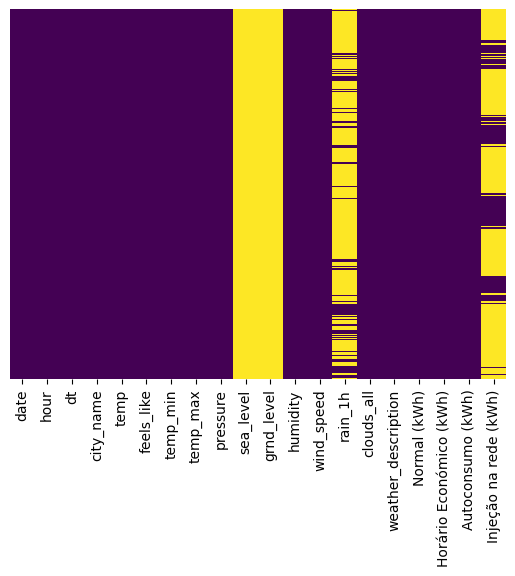

In [21]:
sns.heatmap(df2.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [22]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   date                     8760 non-null   object 
 1   hour                     8760 non-null   int32  
 2   dt                       8760 non-null   int64  
 3   city_name                8760 non-null   object 
 4   temp                     8760 non-null   float64
 5   feels_like               8760 non-null   float64
 6   temp_min                 8760 non-null   float64
 7   temp_max                 8760 non-null   float64
 8   pressure                 8760 non-null   int64  
 9   sea_level                0 non-null      float64
 10  grnd_level               0 non-null      float64
 11  humidity                 8760 non-null   int64  
 12  wind_speed               8760 non-null   float64
 13  rain_1h                  1898 non-null   float64
 14  clouds_all              

In [23]:
df2 = df2.drop(['city_name', 'sea_level', 'grnd_level'], axis=1)
df2

,date,hour,dt,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,rain_1h,clouds_all,weather_description,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),Injeção na rede (kWh)
0,2022-01-01,0,1640995200,16.59,16.00,16.21,16.72,1024,65,3.15,NaN,97,overcast clouds,0.000,0.486,0.0,NaN
1,2022-01-01,1,1640998800,16.59,16.00,16.21,16.72,1024,65,3.14,NaN,58,broken clouds,0.000,0.429,0.0,NaN
2,2022-01-01,2,1641002400,16.59,16.03,15.67,16.72,1024,66,3.12,NaN,23,few clouds,0.000,0.463,0.0,NaN
3,2022-01-01,3,1641006000,13.59,12.75,11.61,16.16,1023,67,3.08,NaN,22,few clouds,0.000,0.545,0.0,NaN
4,2022-01-01,4,1641009600,14.97,14.27,14.72,15.66,1023,67,3.12,NaN,15,few clouds,0.000,0.439,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2022-12-31,19,1672513200,15.70,15.57,15.57,15.72,1018,86,5.56,3.58,100,moderate rain,1.693,0.000,0.0,NaN
8756,2022-12-31,20,1672516800,15.55,15.43,12.72,15.70,1018,87,4.47,4.20,100,heavy intensity rain,1.327,0.000,0.0,NaN
8757,2022-12-31,21,1672520400,13.45,13.28,12.23,13.99,1019,93,3.29,4.23,100,heavy intensity rain,0.757,0.000,0.0,NaN
8758,2022-12-31,22,1672524000,12.93,12.73,12.23,13.43,1019,94,1.49,3.90,100,moderate rain,0.000,0.675,0.0,NaN


In [24]:
# Contagem de valores nulos em cada coluna
print(df2.isnull().sum())

date                          0
hour                          0
dt                            0
temp                          0
feels_like                    0
temp_min                      0
temp_max                      0
pressure                      0
humidity                      0
wind_speed                    0
rain_1h                    6862
clouds_all                    0
weather_description           0
Normal (kWh)                  0
Horário Económico (kWh)       0
Autoconsumo (kWh)             0
Injeção na rede (kWh)      6087
dtype: int64


In [25]:
# Contagem de valores únicos em cada coluna
print(df2.nunique())

date                        365
hour                         24
dt                         8760
temp                       2277
feels_like                 2585
temp_min                    424
temp_max                    511
pressure                     41
humidity                     82
wind_speed                  761
rain_1h                     347
clouds_all                  101
weather_description           8
Normal (kWh)               1132
Horário Económico (kWh)     789
Autoconsumo (kWh)           712
Injeção na rede (kWh)         4
dtype: int64


In [26]:
# Verificar a presença de valores NaN no DataFrame
print(df2.isna().values.any())

True


In [27]:
df2['date'] = pd.to_datetime(df2['date'], format='%Y-%m-%d')

In [28]:
df2['Injeção na rede (kWh)'].replace({None: 'None', np.nan: 'None'}, inplace=True)
df2['rain_1h'].fillna(0, inplace=True)
df2

,date,hour,dt,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,rain_1h,clouds_all,weather_description,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),Injeção na rede (kWh)
0,2022-01-01,0,1640995200,16.59,16.00,16.21,16.72,1024,65,3.15,0.00,97,overcast clouds,0.000,0.486,0.0,None
1,2022-01-01,1,1640998800,16.59,16.00,16.21,16.72,1024,65,3.14,0.00,58,broken clouds,0.000,0.429,0.0,None
2,2022-01-01,2,1641002400,16.59,16.03,15.67,16.72,1024,66,3.12,0.00,23,few clouds,0.000,0.463,0.0,None
3,2022-01-01,3,1641006000,13.59,12.75,11.61,16.16,1023,67,3.08,0.00,22,few clouds,0.000,0.545,0.0,None
4,2022-01-01,4,1641009600,14.97,14.27,14.72,15.66,1023,67,3.12,0.00,15,few clouds,0.000,0.439,0.0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2022-12-31,19,1672513200,15.70,15.57,15.57,15.72,1018,86,5.56,3.58,100,moderate rain,1.693,0.000,0.0,None
8756,2022-12-31,20,1672516800,15.55,15.43,12.72,15.70,1018,87,4.47,4.20,100,heavy intensity rain,1.327,0.000,0.0,None
8757,2022-12-31,21,1672520400,13.45,13.28,12.23,13.99,1019,93,3.29,4.23,100,heavy intensity rain,0.757,0.000,0.0,None
8758,2022-12-31,22,1672524000,12.93,12.73,12.23,13.43,1019,94,1.49,3.90,100,moderate rain,0.000,0.675,0.0,None


In [29]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   date                     8760 non-null   datetime64[ns]
 1   hour                     8760 non-null   int32         
 2   dt                       8760 non-null   int64         
 3   temp                     8760 non-null   float64       
 4   feels_like               8760 non-null   float64       
 5   temp_min                 8760 non-null   float64       
 6   temp_max                 8760 non-null   float64       
 7   pressure                 8760 non-null   int64         
 8   humidity                 8760 non-null   int64         
 9   wind_speed               8760 non-null   float64       
 10  rain_1h                  8760 non-null   float64       
 11  clouds_all               8760 non-null   int64         
 12  weather_description      8760 non-

<Axes: >

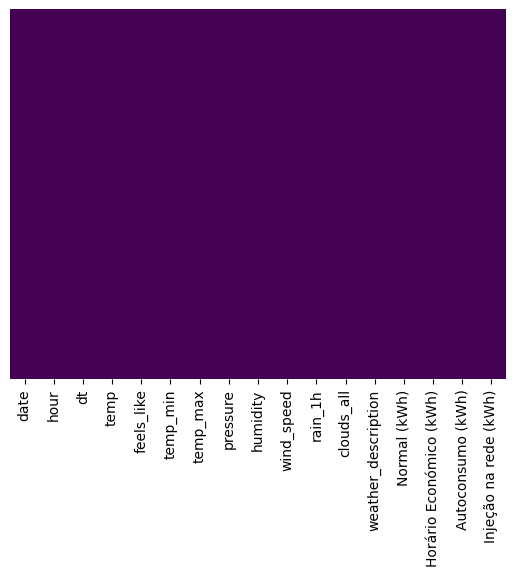

In [30]:
sns.heatmap(df2.isnull(),yticklabels=False,cbar=False,cmap='viridis')

### Tratamento dos dados de 2023

In [31]:
df_meteo3 = pd.read_csv('datasets/meteo_202301-202304.csv', encoding='latin1')
df_energia3 = pd.read_csv('datasets/energia_202301-202304.csv', encoding='latin1') # Temos que prever os valores da energia injetada neste dataset

In [32]:
df_energia3.rename(columns={'Data': 'date', 'Hora': 'hour'}, inplace=True)
df_energia3

,date,hour,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh)
0,2023-01-01,0,0.000,0.467,0.000
1,2023-01-01,1,0.000,0.577,0.000
2,2023-01-01,2,0.000,0.346,0.000
3,2023-01-01,3,0.000,0.270,0.000
4,2023-01-01,4,0.000,0.252,0.000
...,...,...,...,...,...
2251,2023-04-04,19,0.953,0.000,0.012
2252,2023-04-04,20,0.915,0.000,0.000
2253,2023-04-04,21,0.479,0.000,0.000
2254,2023-04-04,22,0.000,0.497,0.000


In [33]:
df_meteo3

,dt,dt_iso,city_name,temp,feels_like,temp_min,temp_max,pressure,sea_level,grnd_level,humidity,wind_speed,rain_1h,clouds_all,weather_description
0,1672531200,2023-01-01 00:00:00 +0000 UTC,local,12.93,12.76,12.72,13.43,1019,NaN,NaN,95,2.02,3.72,100,moderate rain
1,1672534800,2023-01-01 01:00:00 +0000 UTC,local,13.49,13.38,13.43,13.90,1018,NaN,NaN,95,2.18,3.26,100,moderate rain
2,1672538400,2023-01-01 02:00:00 +0000 UTC,local,13.55,13.44,13.48,14.82,1017,NaN,NaN,95,2.88,2.44,100,moderate rain
3,1672542000,2023-01-01 03:00:00 +0000 UTC,local,13.61,13.51,12.01,14.82,1016,NaN,NaN,95,3.63,1.74,100,moderate rain
4,1672545600,2023-01-01 04:00:00 +0000 UTC,local,13.59,13.49,12.01,14.82,1015,NaN,NaN,95,4.58,1.13,100,moderate rain
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1747,1678820400,2023-03-14 19:00:00 +0000 UTC,local,13.10,12.27,12.72,13.60,1024,NaN,NaN,69,1.87,NaN,96,overcast clouds
1748,1678824000,2023-03-14 20:00:00 +0000 UTC,local,12.30,11.83,10.72,12.88,1023,NaN,NaN,86,1.03,NaN,84,broken clouds
1749,1678827600,2023-03-14 21:00:00 +0000 UTC,local,11.77,11.30,10.26,12.88,1023,NaN,NaN,88,1.03,NaN,84,broken clouds
1750,1678831200,2023-03-14 22:00:00 +0000 UTC,local,10.68,10.13,9.15,12.32,1023,NaN,NaN,89,1.03,NaN,84,broken clouds


In [34]:
df_meteo3['dt_iso'] = pd.to_datetime(df_meteo3['dt_iso'], format='%Y-%m-%d %H:%M:%S %z UTC')

df_meteo3['date'] = df_meteo3['dt_iso'].dt.strftime('%Y-%m-%d')
df_meteo3['hour'] = df_meteo3['dt_iso'].dt.hour

df_meteo3 = df_meteo3[['date', 'hour'] + [col for col in df_meteo3.columns if col not in ['dt_iso', 'date', 'hour']]]
df_meteo3

,date,hour,dt,city_name,temp,feels_like,temp_min,temp_max,pressure,sea_level,grnd_level,humidity,wind_speed,rain_1h,clouds_all,weather_description
0,2023-01-01,0,1672531200,local,12.93,12.76,12.72,13.43,1019,NaN,NaN,95,2.02,3.72,100,moderate rain
1,2023-01-01,1,1672534800,local,13.49,13.38,13.43,13.90,1018,NaN,NaN,95,2.18,3.26,100,moderate rain
2,2023-01-01,2,1672538400,local,13.55,13.44,13.48,14.82,1017,NaN,NaN,95,2.88,2.44,100,moderate rain
3,2023-01-01,3,1672542000,local,13.61,13.51,12.01,14.82,1016,NaN,NaN,95,3.63,1.74,100,moderate rain
4,2023-01-01,4,1672545600,local,13.59,13.49,12.01,14.82,1015,NaN,NaN,95,4.58,1.13,100,moderate rain
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1747,2023-03-14,19,1678820400,local,13.10,12.27,12.72,13.60,1024,NaN,NaN,69,1.87,NaN,96,overcast clouds
1748,2023-03-14,20,1678824000,local,12.30,11.83,10.72,12.88,1023,NaN,NaN,86,1.03,NaN,84,broken clouds
1749,2023-03-14,21,1678827600,local,11.77,11.30,10.26,12.88,1023,NaN,NaN,88,1.03,NaN,84,broken clouds
1750,2023-03-14,22,1678831200,local,10.68,10.13,9.15,12.32,1023,NaN,NaN,89,1.03,NaN,84,broken clouds


In [35]:
df3 = pd.merge(df_energia3, df_meteo3, on=['date', 'hour'], how='left')

df3.fillna(0, inplace=True)  # Replace NaN values with 0

print(f"Number of rows in merged DataFrame df3: {len(df3)}")
df3

Number of rows in merged DataFrame df3: 2256


,date,hour,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),dt,city_name,temp,feels_like,temp_min,temp_max,pressure,sea_level,grnd_level,humidity,wind_speed,rain_1h,clouds_all,weather_description
0,2023-01-01,0,0.000,0.467,0.000,1.672531e+09,local,12.93,12.76,12.72,13.43,1019.0,0.0,0.0,95.0,2.02,3.72,100.0,moderate rain
1,2023-01-01,1,0.000,0.577,0.000,1.672535e+09,local,13.49,13.38,13.43,13.90,1018.0,0.0,0.0,95.0,2.18,3.26,100.0,moderate rain
2,2023-01-01,2,0.000,0.346,0.000,1.672538e+09,local,13.55,13.44,13.48,14.82,1017.0,0.0,0.0,95.0,2.88,2.44,100.0,moderate rain
3,2023-01-01,3,0.000,0.270,0.000,1.672542e+09,local,13.61,13.51,12.01,14.82,1016.0,0.0,0.0,95.0,3.63,1.74,100.0,moderate rain
4,2023-01-01,4,0.000,0.252,0.000,1.672546e+09,local,13.59,13.49,12.01,14.82,1015.0,0.0,0.0,95.0,4.58,1.13,100.0,moderate rain
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2251,2023-04-04,19,0.953,0.000,0.012,0.000000e+00,0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0
2252,2023-04-04,20,0.915,0.000,0.000,0.000000e+00,0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0
2253,2023-04-04,21,0.479,0.000,0.000,0.000000e+00,0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0
2254,2023-04-04,22,0.000,0.497,0.000,0.000000e+00,0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0


In [36]:
df3 = df3.drop(['city_name', 'sea_level', 'grnd_level', 'weather_description'], axis=1)
df3['date'] = pd.to_datetime(df3['date'], format='%Y-%m-%d')
df3['rain_1h'].fillna(0, inplace=True)
df3['Injeção na rede (kWh)'] = np.nan
df3['Injeção na rede (kWh)'].replace({None: 'None', np.nan: 'None'}, inplace=True)
df3

,date,hour,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),dt,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,rain_1h,clouds_all,Injeção na rede (kWh)
0,2023-01-01,0,0.000,0.467,0.000,1.672531e+09,12.93,12.76,12.72,13.43,1019.0,95.0,2.02,3.72,100.0,None
1,2023-01-01,1,0.000,0.577,0.000,1.672535e+09,13.49,13.38,13.43,13.90,1018.0,95.0,2.18,3.26,100.0,None
2,2023-01-01,2,0.000,0.346,0.000,1.672538e+09,13.55,13.44,13.48,14.82,1017.0,95.0,2.88,2.44,100.0,None
3,2023-01-01,3,0.000,0.270,0.000,1.672542e+09,13.61,13.51,12.01,14.82,1016.0,95.0,3.63,1.74,100.0,None
4,2023-01-01,4,0.000,0.252,0.000,1.672546e+09,13.59,13.49,12.01,14.82,1015.0,95.0,4.58,1.13,100.0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2251,2023-04-04,19,0.953,0.000,0.012,0.000000e+00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.0,None
2252,2023-04-04,20,0.915,0.000,0.000,0.000000e+00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.0,None
2253,2023-04-04,21,0.479,0.000,0.000,0.000000e+00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.0,None
2254,2023-04-04,22,0.000,0.497,0.000,0.000000e+00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.0,None


### Tratamento da dados da net (df_open)

In [37]:
df_open

,time,weather_code (wmo code),cloud_cover (%),cloud_cover_low (%),cloud_cover_mid (%),cloud_cover_high (%),sunshine_duration (s),shortwave_radiation (W/m²),direct_radiation (W/m²),diffuse_radiation (W/m²),direct_normal_irradiance (W/m²),terrestrial_radiation (W/m²),shortwave_radiation_instant (W/m²),direct_radiation_instant (W/m²),diffuse_radiation_instant (W/m²),direct_normal_irradiance_instant (W/m²),terrestrial_radiation_instant (W/m²)
0,2021-09-29T00:00,1,23,0,0,78,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2021-09-29T01:00,1,22,0,0,73,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2021-09-29T02:00,1,23,0,0,77,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2021-09-29T03:00,0,14,0,0,46,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2021-09-29T04:00,0,11,0,0,38,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11011,2022-12-31T19:00,61,100,100,100,100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11012,2022-12-31T20:00,63,100,100,99,100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11013,2022-12-31T21:00,63,100,100,100,100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11014,2022-12-31T22:00,63,100,100,100,100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
df_open2

,time,weather_code (wmo code),cloud_cover (%),cloud_cover_low (%),cloud_cover_mid (%),cloud_cover_high (%),sunshine_duration (s),shortwave_radiation (W/m²),direct_radiation (W/m²),diffuse_radiation (W/m²),direct_normal_irradiance (W/m²),terrestrial_radiation (W/m²),shortwave_radiation_instant (W/m²),direct_radiation_instant (W/m²),diffuse_radiation_instant (W/m²),direct_normal_irradiance_instant (W/m²),terrestrial_radiation_instant (W/m²)
0,2023-01-01T00:00,63,100,100,100,100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2023-01-01T01:00,63,100,100,100,100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2023-01-01T02:00,65,100,100,100,100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2023-01-01T03:00,65,100,100,100,100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2023-01-01T04:00,63,100,100,100,100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2251,2023-04-04T19:00,0,0,0,0,0,2102.5,59.0,35.0,24.0,270.4,121.7,0.0,0.0,0.0,0.0,0.0
2252,2023-04-04T20:00,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2253,2023-04-04T21:00,0,2,0,0,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2254,2023-04-04T22:00,0,1,0,0,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
df_open['time'] = pd.to_datetime(df_open['time'], format='%Y-%m-%dT%H:%M')

df_open['date'] = df_open['time'].dt.date
df_open['hour'] = df_open['time'].dt.hour

df_open = df_open[['date', 'hour'] + [col for col in df_open.columns if col not in ['date', 'hour']]]
df_open['date'] = pd.to_datetime(df_open['date'])

df_open = df_open.drop('time', axis=1)

df_open

,date,hour,weather_code (wmo code),cloud_cover (%),cloud_cover_low (%),cloud_cover_mid (%),cloud_cover_high (%),sunshine_duration (s),shortwave_radiation (W/m²),direct_radiation (W/m²),diffuse_radiation (W/m²),direct_normal_irradiance (W/m²),terrestrial_radiation (W/m²),shortwave_radiation_instant (W/m²),direct_radiation_instant (W/m²),diffuse_radiation_instant (W/m²),direct_normal_irradiance_instant (W/m²),terrestrial_radiation_instant (W/m²)
0,2021-09-29,0,1,23,0,0,78,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2021-09-29,1,1,22,0,0,73,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2021-09-29,2,1,23,0,0,77,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2021-09-29,3,0,14,0,0,46,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2021-09-29,4,0,11,0,0,38,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11011,2022-12-31,19,61,100,100,100,100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11012,2022-12-31,20,63,100,100,99,100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11013,2022-12-31,21,63,100,100,100,100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11014,2022-12-31,22,63,100,100,100,100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
df_open.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11016 entries, 0 to 11015
Data columns (total 18 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   date                                     11016 non-null  datetime64[ns]
 1   hour                                     11016 non-null  int32         
 2   weather_code (wmo code)                  11016 non-null  int64         
 3   cloud_cover (%)                          11016 non-null  int64         
 4   cloud_cover_low (%)                      11016 non-null  int64         
 5   cloud_cover_mid (%)                      11016 non-null  int64         
 6   cloud_cover_high (%)                     11016 non-null  int64         
 7   sunshine_duration (s)                    11016 non-null  float64       
 8   shortwave_radiation (W/m²)               11016 non-null  float64       
 9   direct_radiation (W/m²)                

<Axes: >

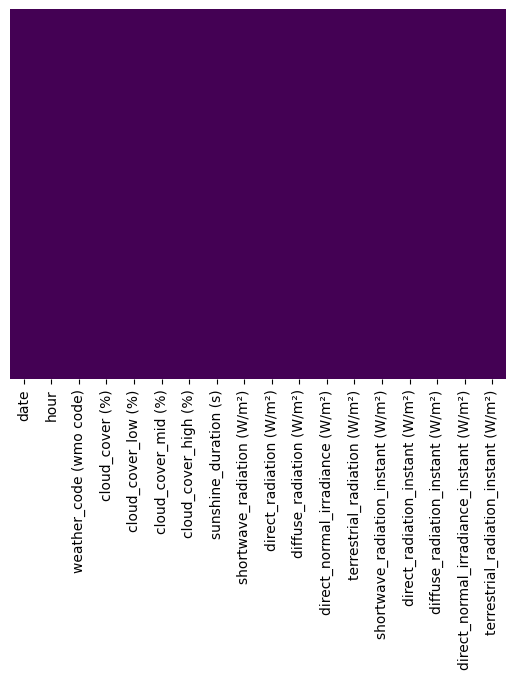

In [41]:
sns.heatmap(df_open.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [42]:
print(df_open.nunique())

date                                        459
hour                                         24
weather_code (wmo code)                      10
cloud_cover (%)                             101
cloud_cover_low (%)                         101
cloud_cover_mid (%)                         101
cloud_cover_high (%)                        101
sunshine_duration (s)                       919
shortwave_radiation (W/m²)                  935
direct_radiation (W/m²)                     816
diffuse_radiation (W/m²)                    363
direct_normal_irradiance (W/m²)            3681
terrestrial_radiation (W/m²)               4475
shortwave_radiation_instant (W/m²)         3821
direct_radiation_instant (W/m²)            3186
diffuse_radiation_instant (W/m²)           2116
direct_normal_irradiance_instant (W/m²)    3562
terrestrial_radiation_instant (W/m²)       4259
dtype: int64


In [43]:
df_open2['time'] = pd.to_datetime(df_open2['time'], format='%Y-%m-%dT%H:%M')

df_open2['date'] = df_open2['time'].dt.date
df_open2['hour'] = df_open2['time'].dt.hour

df_open2 = df_open2[['date', 'hour'] + [col for col in df_open2.columns if col not in ['date', 'hour']]]
df_open2['date'] = pd.to_datetime(df_open2['date'])

df_open2 = df_open2.drop('time', axis=1)

df_open2

,date,hour,weather_code (wmo code),cloud_cover (%),cloud_cover_low (%),cloud_cover_mid (%),cloud_cover_high (%),sunshine_duration (s),shortwave_radiation (W/m²),direct_radiation (W/m²),diffuse_radiation (W/m²),direct_normal_irradiance (W/m²),terrestrial_radiation (W/m²),shortwave_radiation_instant (W/m²),direct_radiation_instant (W/m²),diffuse_radiation_instant (W/m²),direct_normal_irradiance_instant (W/m²),terrestrial_radiation_instant (W/m²)
0,2023-01-01,0,63,100,100,100,100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2023-01-01,1,63,100,100,100,100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2023-01-01,2,65,100,100,100,100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2023-01-01,3,65,100,100,100,100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2023-01-01,4,63,100,100,100,100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2251,2023-04-04,19,0,0,0,0,0,2102.5,59.0,35.0,24.0,270.4,121.7,0.0,0.0,0.0,0.0,0.0
2252,2023-04-04,20,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2253,2023-04-04,21,0,2,0,0,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2254,2023-04-04,22,0,1,0,0,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
df_open3

,time,temperature_2m (°C),relative_humidity_2m (%),apparent_temperature (°C),rain (mm),surface_pressure (hPa),cloud_cover (%),wind_speed_10m (km/h)
0,2023-03-15T00:00,7.6,92,6.1,0.0,999.5,0,4.7
1,2023-03-15T01:00,6.7,94,4.8,0.0,998.9,2,5.9
2,2023-03-15T02:00,5.8,94,3.7,0.0,998.7,2,6.6
3,2023-03-15T03:00,5.2,94,3.1,0.0,998.1,5,5.4
4,2023-03-15T04:00,4.5,95,2.5,0.0,996.9,0,4.0
...,...,...,...,...,...,...,...,...
499,2023-04-04T19:00,20.1,35,18.1,0.0,992.6,0,4.3
500,2023-04-04T20:00,13.6,63,11.5,0.0,993.1,0,8.9
501,2023-04-04T21:00,12.6,67,10.6,0.0,993.9,2,8.0
502,2023-04-04T22:00,11.7,68,9.5,0.0,994.3,1,8.7


In [45]:
df_open3['time'] = pd.to_datetime(df_open3['time'], format='%Y-%m-%dT%H:%M')

df_open3['date'] = df_open3['time'].dt.date
df_open3['hour'] = df_open3['time'].dt.hour

df_open3 = df_open3[['date', 'hour'] + [col for col in df_open3.columns if col not in ['date', 'hour']]]
df_open3['date'] = pd.to_datetime(df_open3['date'])

df_open3 = df_open3.drop('time', axis=1)

df_open3

,date,hour,temperature_2m (°C),relative_humidity_2m (%),apparent_temperature (°C),rain (mm),surface_pressure (hPa),cloud_cover (%),wind_speed_10m (km/h)
0,2023-03-15,0,7.6,92,6.1,0.0,999.5,0,4.7
1,2023-03-15,1,6.7,94,4.8,0.0,998.9,2,5.9
2,2023-03-15,2,5.8,94,3.7,0.0,998.7,2,6.6
3,2023-03-15,3,5.2,94,3.1,0.0,998.1,5,5.4
4,2023-03-15,4,4.5,95,2.5,0.0,996.9,0,4.0
...,...,...,...,...,...,...,...,...,...
499,2023-04-04,19,20.1,35,18.1,0.0,992.6,0,4.3
500,2023-04-04,20,13.6,63,11.5,0.0,993.1,0,8.9
501,2023-04-04,21,12.6,67,10.6,0.0,993.9,2,8.0
502,2023-04-04,22,11.7,68,9.5,0.0,994.3,1,8.7


In [46]:
df_open4.rename(columns={'time': 'date'}, inplace=True)
df_open4['date'] = pd.to_datetime(df_open4['date'])
df_open4

,date,temperature_2m_max (°C),temperature_2m_min (°C)
0,2023-03-15,19.5,3.2
1,2023-03-16,17.6,6.3
2,2023-03-17,14.0,9.0
3,2023-03-18,15.3,7.1
4,2023-03-19,17.8,4.6
5,2023-03-20,19.1,4.8
6,2023-03-21,16.8,7.8
7,2023-03-22,14.9,8.8
8,2023-03-23,13.9,11.8
9,2023-03-24,15.9,8.7


In [47]:
df_open4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   date                     21 non-null     datetime64[ns]
 1   temperature_2m_max (°C)  21 non-null     float64       
 2   temperature_2m_min (°C)  21 non-null     float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 636.0 bytes


Junção do df_open3 e df_open4 (dados de 2023)

In [48]:
df_merged = pd.merge(df_open3, df_open4, on='date', how='left')
df_merged

,date,hour,temperature_2m (°C),relative_humidity_2m (%),apparent_temperature (°C),rain (mm),surface_pressure (hPa),cloud_cover (%),wind_speed_10m (km/h),temperature_2m_max (°C),temperature_2m_min (°C)
0,2023-03-15,0,7.6,92,6.1,0.0,999.5,0,4.7,19.5,3.2
1,2023-03-15,1,6.7,94,4.8,0.0,998.9,2,5.9,19.5,3.2
2,2023-03-15,2,5.8,94,3.7,0.0,998.7,2,6.6,19.5,3.2
3,2023-03-15,3,5.2,94,3.1,0.0,998.1,5,5.4,19.5,3.2
4,2023-03-15,4,4.5,95,2.5,0.0,996.9,0,4.0,19.5,3.2
...,...,...,...,...,...,...,...,...,...,...,...
499,2023-04-04,19,20.1,35,18.1,0.0,992.6,0,4.3,22.0,5.7
500,2023-04-04,20,13.6,63,11.5,0.0,993.1,0,8.9,22.0,5.7
501,2023-04-04,21,12.6,67,10.6,0.0,993.9,2,8.0,22.0,5.7
502,2023-04-04,22,11.7,68,9.5,0.0,994.3,1,8.7,22.0,5.7


In [49]:
column_mapping = {
    'temperature_2m (°C)': 'temp',
    'relative_humidity_2m (%)': 'humidity',
    'apparent_temperature (°C)': 'feels_like',
    'rain (mm)': 'rain_1h',
    'surface_pressure (hPa)': 'pressure',
    'cloud_cover (%)': 'clouds_all',
    'wind_speed_10m (km/h)': 'wind_speed',
    'temperature_2m_min (°C)': 'temp_min',
    'temperature_2m_max (°C)': 'temp_max',
}

#df_open = df_open.drop(['precipitation_hours (h)'], axis=1)

df_merged.rename(columns=column_mapping, inplace=True)
df_merged

,date,hour,temp,humidity,feels_like,rain_1h,pressure,clouds_all,wind_speed,temp_max,temp_min
0,2023-03-15,0,7.6,92,6.1,0.0,999.5,0,4.7,19.5,3.2
1,2023-03-15,1,6.7,94,4.8,0.0,998.9,2,5.9,19.5,3.2
2,2023-03-15,2,5.8,94,3.7,0.0,998.7,2,6.6,19.5,3.2
3,2023-03-15,3,5.2,94,3.1,0.0,998.1,5,5.4,19.5,3.2
4,2023-03-15,4,4.5,95,2.5,0.0,996.9,0,4.0,19.5,3.2
...,...,...,...,...,...,...,...,...,...,...,...
499,2023-04-04,19,20.1,35,18.1,0.0,992.6,0,4.3,22.0,5.7
500,2023-04-04,20,13.6,63,11.5,0.0,993.1,0,8.9,22.0,5.7
501,2023-04-04,21,12.6,67,10.6,0.0,993.9,2,8.0,22.0,5.7
502,2023-04-04,22,11.7,68,9.5,0.0,994.3,1,8.7,22.0,5.7


### Junção dos dataframes de 2021 e 2022

In [50]:
df = pd.concat([df1, df2], ignore_index=True)
df = df.drop(['weather_description'], axis=1)
df

,date,hour,dt,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,rain_1h,clouds_all,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),Injeção na rede (kWh)
0,2021-09-29,0,1632873600,13.97,13.54,11.45,14.04,1027,81,1.96,0.00,87,0.000,0.000,0.0,None
1,2021-09-29,1,1632877200,13.48,13.02,13.43,13.90,1028,82,1.83,0.00,91,0.000,0.000,0.0,None
2,2021-09-29,2,1632880800,12.93,12.47,12.72,13.43,1027,84,1.96,0.00,93,0.000,0.000,0.0,None
3,2021-09-29,3,1632884400,12.61,12.15,10.34,12.93,1027,85,1.85,0.00,95,0.000,0.000,0.0,None
4,2021-09-29,4,1632888000,12.61,12.17,9.79,12.93,1027,86,1.83,0.00,93,0.000,0.000,0.0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11011,2022-12-31,19,1672513200,15.70,15.57,15.57,15.72,1018,86,5.56,3.58,100,1.693,0.000,0.0,None
11012,2022-12-31,20,1672516800,15.55,15.43,12.72,15.70,1018,87,4.47,4.20,100,1.327,0.000,0.0,None
11013,2022-12-31,21,1672520400,13.45,13.28,12.23,13.99,1019,93,3.29,4.23,100,0.757,0.000,0.0,None
11014,2022-12-31,22,1672524000,12.93,12.73,12.23,13.43,1019,94,1.49,3.90,100,0.000,0.675,0.0,None


In [51]:
value_counts = df['Injeção na rede (kWh)'].value_counts(dropna=False)
print(value_counts)

Injeção na rede (kWh)
None         7777
High         1103
Medium       1098
Very High     606
Low           432
Name: count, dtype: int64


In [52]:
df_open

,date,hour,weather_code (wmo code),cloud_cover (%),cloud_cover_low (%),cloud_cover_mid (%),cloud_cover_high (%),sunshine_duration (s),shortwave_radiation (W/m²),direct_radiation (W/m²),diffuse_radiation (W/m²),direct_normal_irradiance (W/m²),terrestrial_radiation (W/m²),shortwave_radiation_instant (W/m²),direct_radiation_instant (W/m²),diffuse_radiation_instant (W/m²),direct_normal_irradiance_instant (W/m²),terrestrial_radiation_instant (W/m²)
0,2021-09-29,0,1,23,0,0,78,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2021-09-29,1,1,22,0,0,73,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2021-09-29,2,1,23,0,0,77,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2021-09-29,3,0,14,0,0,46,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2021-09-29,4,0,11,0,0,38,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11011,2022-12-31,19,61,100,100,100,100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11012,2022-12-31,20,63,100,100,99,100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11013,2022-12-31,21,63,100,100,100,100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11014,2022-12-31,22,63,100,100,100,100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
df = pd.merge(df, df_open, on=['date', 'hour'], how='inner')
df

,date,hour,dt,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,...,shortwave_radiation (W/m²),direct_radiation (W/m²),diffuse_radiation (W/m²),direct_normal_irradiance (W/m²),terrestrial_radiation (W/m²),shortwave_radiation_instant (W/m²),direct_radiation_instant (W/m²),diffuse_radiation_instant (W/m²),direct_normal_irradiance_instant (W/m²),terrestrial_radiation_instant (W/m²)
0,2021-09-29,0,1632873600,13.97,13.54,11.45,14.04,1027,81,1.96,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2021-09-29,1,1632877200,13.48,13.02,13.43,13.90,1028,82,1.83,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2021-09-29,2,1632880800,12.93,12.47,12.72,13.43,1027,84,1.96,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2021-09-29,3,1632884400,12.61,12.15,10.34,12.93,1027,85,1.85,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2021-09-29,4,1632888000,12.61,12.17,9.79,12.93,1027,86,1.83,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11011,2022-12-31,19,1672513200,15.70,15.57,15.57,15.72,1018,86,5.56,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11012,2022-12-31,20,1672516800,15.55,15.43,12.72,15.70,1018,87,4.47,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11013,2022-12-31,21,1672520400,13.45,13.28,12.23,13.99,1019,93,3.29,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11014,2022-12-31,22,1672524000,12.93,12.73,12.23,13.43,1019,94,1.49,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11016 entries, 0 to 11015
Data columns (total 32 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   date                                     11016 non-null  datetime64[ns]
 1   hour                                     11016 non-null  int32         
 2   dt                                       11016 non-null  int64         
 3   temp                                     11016 non-null  float64       
 4   feels_like                               11016 non-null  float64       
 5   temp_min                                 11016 non-null  float64       
 6   temp_max                                 11016 non-null  float64       
 7   pressure                                 11016 non-null  int64         
 8   humidity                                 11016 non-null  int64         
 9   wind_speed                             

A partir daqui usa-se este dataframe para fazer o treinamento dos dados porque agora está mais completo e cheio de informações e dados

### Junção dos dados de 2023 e da net

In [55]:
df3

,date,hour,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),dt,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,rain_1h,clouds_all,Injeção na rede (kWh)
0,2023-01-01,0,0.000,0.467,0.000,1.672531e+09,12.93,12.76,12.72,13.43,1019.0,95.0,2.02,3.72,100.0,None
1,2023-01-01,1,0.000,0.577,0.000,1.672535e+09,13.49,13.38,13.43,13.90,1018.0,95.0,2.18,3.26,100.0,None
2,2023-01-01,2,0.000,0.346,0.000,1.672538e+09,13.55,13.44,13.48,14.82,1017.0,95.0,2.88,2.44,100.0,None
3,2023-01-01,3,0.000,0.270,0.000,1.672542e+09,13.61,13.51,12.01,14.82,1016.0,95.0,3.63,1.74,100.0,None
4,2023-01-01,4,0.000,0.252,0.000,1.672546e+09,13.59,13.49,12.01,14.82,1015.0,95.0,4.58,1.13,100.0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2251,2023-04-04,19,0.953,0.000,0.012,0.000000e+00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.0,None
2252,2023-04-04,20,0.915,0.000,0.000,0.000000e+00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.0,None
2253,2023-04-04,21,0.479,0.000,0.000,0.000000e+00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.0,None
2254,2023-04-04,22,0.000,0.497,0.000,0.000000e+00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.0,None


In [56]:
matching_rows = df3[(df3['date'] == '2023-03-14') & (df3['hour'] == 23.0)]

split_index = matching_rows.index[0]

df3_before = df3.loc[:split_index]
df3_after = df3.loc[split_index + 1:]

In [57]:
df3_before

,date,hour,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),dt,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,rain_1h,clouds_all,Injeção na rede (kWh)
0,2023-01-01,0,0.000,0.467,0.0,1.672531e+09,12.93,12.76,12.72,13.43,1019.0,95.0,2.02,3.72,100.0,None
1,2023-01-01,1,0.000,0.577,0.0,1.672535e+09,13.49,13.38,13.43,13.90,1018.0,95.0,2.18,3.26,100.0,None
2,2023-01-01,2,0.000,0.346,0.0,1.672538e+09,13.55,13.44,13.48,14.82,1017.0,95.0,2.88,2.44,100.0,None
3,2023-01-01,3,0.000,0.270,0.0,1.672542e+09,13.61,13.51,12.01,14.82,1016.0,95.0,3.63,1.74,100.0,None
4,2023-01-01,4,0.000,0.252,0.0,1.672546e+09,13.59,13.49,12.01,14.82,1015.0,95.0,4.58,1.13,100.0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1747,2023-03-14,19,0.329,0.000,0.0,1.678820e+09,13.10,12.27,12.72,13.60,1024.0,69.0,1.87,0.00,96.0,None
1748,2023-03-14,20,0.401,0.000,0.0,1.678824e+09,12.30,11.83,10.72,12.88,1023.0,86.0,1.03,0.00,84.0,None
1749,2023-03-14,21,0.670,0.000,0.0,1.678828e+09,11.77,11.30,10.26,12.88,1023.0,88.0,1.03,0.00,84.0,None
1750,2023-03-14,22,0.000,0.558,0.0,1.678831e+09,10.68,10.13,9.15,12.32,1023.0,89.0,1.03,0.00,84.0,None


In [58]:
df3_after

,date,hour,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),dt,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,rain_1h,clouds_all,Injeção na rede (kWh)
1752,2023-03-15,0,0.000,0.502,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None
1753,2023-03-15,1,0.000,0.504,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None
1754,2023-03-15,2,0.000,0.494,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None
1755,2023-03-15,3,0.000,0.495,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None
1756,2023-03-15,4,0.000,0.349,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2251,2023-04-04,19,0.953,0.000,0.012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None
2252,2023-04-04,20,0.915,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None
2253,2023-04-04,21,0.479,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None
2254,2023-04-04,22,0.000,0.497,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None


In [59]:
df3_after.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 504 entries, 1752 to 2255
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   date                     504 non-null    datetime64[ns]
 1   hour                     504 non-null    int64         
 2   Normal (kWh)             504 non-null    float64       
 3   Horário Económico (kWh)  504 non-null    float64       
 4   Autoconsumo (kWh)        504 non-null    float64       
 5   dt                       504 non-null    float64       
 6   temp                     504 non-null    float64       
 7   feels_like               504 non-null    float64       
 8   temp_min                 504 non-null    float64       
 9   temp_max                 504 non-null    float64       
 10  pressure                 504 non-null    float64       
 11  humidity                 504 non-null    float64       
 12  wind_speed               504 non

In [60]:
df_merged

,date,hour,temp,humidity,feels_like,rain_1h,pressure,clouds_all,wind_speed,temp_max,temp_min
0,2023-03-15,0,7.6,92,6.1,0.0,999.5,0,4.7,19.5,3.2
1,2023-03-15,1,6.7,94,4.8,0.0,998.9,2,5.9,19.5,3.2
2,2023-03-15,2,5.8,94,3.7,0.0,998.7,2,6.6,19.5,3.2
3,2023-03-15,3,5.2,94,3.1,0.0,998.1,5,5.4,19.5,3.2
4,2023-03-15,4,4.5,95,2.5,0.0,996.9,0,4.0,19.5,3.2
...,...,...,...,...,...,...,...,...,...,...,...
499,2023-04-04,19,20.1,35,18.1,0.0,992.6,0,4.3,22.0,5.7
500,2023-04-04,20,13.6,63,11.5,0.0,993.1,0,8.9,22.0,5.7
501,2023-04-04,21,12.6,67,10.6,0.0,993.9,2,8.0,22.0,5.7
502,2023-04-04,22,11.7,68,9.5,0.0,994.3,1,8.7,22.0,5.7


In [61]:
df3_after.set_index('date', inplace=True)
df_merged.set_index('date', inplace=True)

df3_after.update(df_merged)

df3_after.reset_index(inplace=True)

df3_after

,date,hour,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),dt,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,rain_1h,clouds_all,Injeção na rede (kWh)
0,2023-03-15,0,0.000,0.502,0.000,0.0,7.6,6.1,3.2,19.5,999.5,92.0,4.7,0.0,0.0,None
1,2023-03-15,1,0.000,0.504,0.000,0.0,6.7,4.8,3.2,19.5,998.9,94.0,5.9,0.0,2.0,None
2,2023-03-15,2,0.000,0.494,0.000,0.0,5.8,3.7,3.2,19.5,998.7,94.0,6.6,0.0,2.0,None
3,2023-03-15,3,0.000,0.495,0.000,0.0,5.2,3.1,3.2,19.5,998.1,94.0,5.4,0.0,5.0,None
4,2023-03-15,4,0.000,0.349,0.000,0.0,4.5,2.5,3.2,19.5,996.9,95.0,4.0,0.0,0.0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499,2023-04-04,19,0.953,0.000,0.012,0.0,20.1,18.1,5.7,22.0,992.6,35.0,4.3,0.0,0.0,None
500,2023-04-04,20,0.915,0.000,0.000,0.0,13.6,11.5,5.7,22.0,993.1,63.0,8.9,0.0,0.0,None
501,2023-04-04,21,0.479,0.000,0.000,0.0,12.6,10.6,5.7,22.0,993.9,67.0,8.0,0.0,2.0,None
502,2023-04-04,22,0.000,0.497,0.000,0.0,11.7,9.5,5.7,22.0,994.3,68.0,8.7,0.0,1.0,None


In [62]:
df3 = pd.concat([df3_before, df3_after], ignore_index=True)
df3

,date,hour,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),dt,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,rain_1h,clouds_all,Injeção na rede (kWh)
0,2023-01-01,0,0.000,0.467,0.000,1.672531e+09,12.93,12.76,12.72,13.43,1019.0,95.0,2.02,3.72,100.0,None
1,2023-01-01,1,0.000,0.577,0.000,1.672535e+09,13.49,13.38,13.43,13.90,1018.0,95.0,2.18,3.26,100.0,None
2,2023-01-01,2,0.000,0.346,0.000,1.672538e+09,13.55,13.44,13.48,14.82,1017.0,95.0,2.88,2.44,100.0,None
3,2023-01-01,3,0.000,0.270,0.000,1.672542e+09,13.61,13.51,12.01,14.82,1016.0,95.0,3.63,1.74,100.0,None
4,2023-01-01,4,0.000,0.252,0.000,1.672546e+09,13.59,13.49,12.01,14.82,1015.0,95.0,4.58,1.13,100.0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2251,2023-04-04,19,0.953,0.000,0.012,0.000000e+00,20.10,18.10,5.70,22.00,992.6,35.0,4.30,0.00,0.0,None
2252,2023-04-04,20,0.915,0.000,0.000,0.000000e+00,13.60,11.50,5.70,22.00,993.1,63.0,8.90,0.00,0.0,None
2253,2023-04-04,21,0.479,0.000,0.000,0.000000e+00,12.60,10.60,5.70,22.00,993.9,67.0,8.00,0.00,2.0,None
2254,2023-04-04,22,0.000,0.497,0.000,0.000000e+00,11.70,9.50,5.70,22.00,994.3,68.0,8.70,0.00,1.0,None


In [63]:
df3 = pd.merge(df3, df_open2, on=['date', 'hour'], how='inner')
df3

,date,hour,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),dt,temp,feels_like,temp_min,temp_max,...,shortwave_radiation (W/m²),direct_radiation (W/m²),diffuse_radiation (W/m²),direct_normal_irradiance (W/m²),terrestrial_radiation (W/m²),shortwave_radiation_instant (W/m²),direct_radiation_instant (W/m²),diffuse_radiation_instant (W/m²),direct_normal_irradiance_instant (W/m²),terrestrial_radiation_instant (W/m²)
0,2023-01-01,0,0.000,0.467,0.000,1.672531e+09,12.93,12.76,12.72,13.43,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2023-01-01,1,0.000,0.577,0.000,1.672535e+09,13.49,13.38,13.43,13.90,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2023-01-01,2,0.000,0.346,0.000,1.672538e+09,13.55,13.44,13.48,14.82,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2023-01-01,3,0.000,0.270,0.000,1.672542e+09,13.61,13.51,12.01,14.82,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2023-01-01,4,0.000,0.252,0.000,1.672546e+09,13.59,13.49,12.01,14.82,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2251,2023-04-04,19,0.953,0.000,0.012,0.000000e+00,20.10,18.10,5.70,22.00,...,59.0,35.0,24.0,270.4,121.7,0.0,0.0,0.0,0.0,0.0
2252,2023-04-04,20,0.915,0.000,0.000,0.000000e+00,13.60,11.50,5.70,22.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2253,2023-04-04,21,0.479,0.000,0.000,0.000000e+00,12.60,10.60,5.70,22.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2254,2023-04-04,22,0.000,0.497,0.000,0.000000e+00,11.70,9.50,5.70,22.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2256 entries, 0 to 2255
Data columns (total 32 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   date                                     2256 non-null   datetime64[ns]
 1   hour                                     2256 non-null   int64         
 2   Normal (kWh)                             2256 non-null   float64       
 3   Horário Económico (kWh)                  2256 non-null   float64       
 4   Autoconsumo (kWh)                        2256 non-null   float64       
 5   dt                                       2256 non-null   float64       
 6   temp                                     2256 non-null   float64       
 7   feels_like                               2256 non-null   float64       
 8   temp_min                                 2256 non-null   float64       
 9   temp_max                                 

Os valores da 'Injeção da rede (kWh)' de df3 estão todos a 'None' porque a coluna foi adicionada manualmente

# Modelos bonitos <3

Mensagem para os meus friendos lindos: <br/>
Temos que fazer o treinamento dos dados usando o dataframe 'df' todo e dps pegar no dataframe 'df_energia3' e prever os valores dos dados da coluna 'Injeção na rede (KWh)'<br/>
Primeiro podemos usar o dataframe 'df' apenas para comparar resultados de acuracy entre os modelos diferentes que usarmos e dps escolher o melhor para prever os valores do dataframe 'df_energia3'

## Feature Engineering, Decision Tree Pruning and Hyperparameter Tuning


<Axes: >

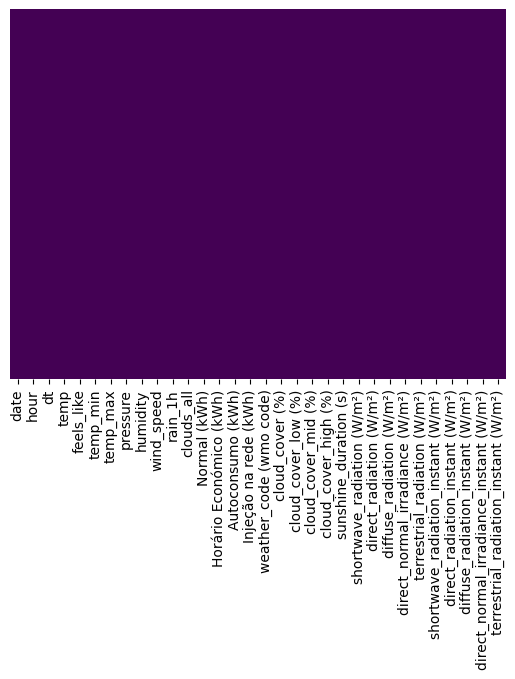

In [65]:
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [66]:
print(df['Injeção na rede (kWh)'].value_counts().count())

5


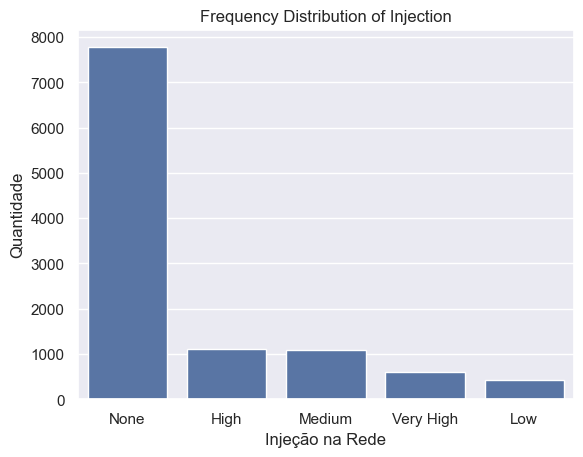

In [67]:
injecao_count = df['Injeção na rede (kWh)'].value_counts()
sns.set(style='darkgrid')
sns.barplot(x=injecao_count.index, y=injecao_count.values)
plt.title('Frequency Distribution of Injection')
plt.ylabel('Quantidade', fontsize=12)
plt.xlabel('Injeção na Rede', fontsize=12)
plt.show()

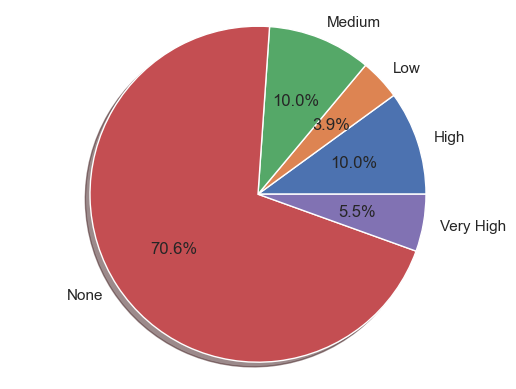

In [68]:
labels = df['Injeção na rede (kWh)'].astype('category').cat.categories.tolist()
counts = df['Injeção na rede (kWh)'].value_counts()
sizes = [counts[var_cat] for var_cat in labels]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True)
ax1.axis('equal')
plt.show()

We have several options how to deal with qualitative data:

#### a) Replace values

In [69]:
df_r1=df.copy()

We need to create a dictionary assigning the string to a numeric value: (Isto é importante!)

None - 0, Low - 1, Medium - 2, High - 3, Very High - 4 (NA PARTE DOS LABELS DÁ DIFERENTE, MAS NÃO EXISTE PROBLEMA NENHUM, VAI DAR AO MESMO)

O mesmo irá ser feito para o weather_description 

In [70]:
replace_map = {'Injeção na rede (kWh)' : {'None': 0, 'Low' : 1, 'Medium': 2, 'High': 3, 'Very High': 4}}
#replace_map = {'weather_description' : {'sky is clear': 0, 'overcast clouds' : 1, 'light rain': 2, 'broken clouds': 3, 'scattered clouds': 4, "few clouds": 5, 'moderate rain': 6, 'heavy intensity rain': 7}}

In [71]:
labels = df_r1['Injeção na rede (kWh)'].astype('category').cat.categories.tolist()
replace_map_comp = {'Injeção na rede (kWh)' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}
print(replace_map_comp)
# labels = df_r1['weather_description'].astype('category').cat.categories.tolist()
# replace_map_comp2 = {'weather_description' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}
# print(replace_map_comp2)

{'Injeção na rede (kWh)': {'High': 1, 'Low': 2, 'Medium': 3, 'None': 4, 'Very High': 5}}


In [72]:
df_r1.replace(replace_map_comp, inplace=True)
# df_r1.replace(replace_map_comp2, inplace=True)

df_r1.head()

,date,hour,dt,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,...,shortwave_radiation (W/m²),direct_radiation (W/m²),diffuse_radiation (W/m²),direct_normal_irradiance (W/m²),terrestrial_radiation (W/m²),shortwave_radiation_instant (W/m²),direct_radiation_instant (W/m²),diffuse_radiation_instant (W/m²),direct_normal_irradiance_instant (W/m²),terrestrial_radiation_instant (W/m²)
0,2021-09-29,0,1632873600,13.97,13.54,11.45,14.04,1027,81,1.96,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2021-09-29,1,1632877200,13.48,13.02,13.43,13.90,1028,82,1.83,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2021-09-29,2,1632880800,12.93,12.47,12.72,13.43,1027,84,1.96,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2021-09-29,3,1632884400,12.61,12.15,10.34,12.93,1027,85,1.85,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2021-09-29,4,1632888000,12.61,12.17,9.79,12.93,1027,86,1.83,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [73]:
print(df_r1['Injeção na rede (kWh)'].dtypes)
# print(df_r1['weather_description'].dtypes)

int64


#### b) Label-Encoding

In [74]:
df_r2=df.copy()

In [75]:
print(df_r2.dtypes)

date                                       datetime64[ns]
hour                                                int32
dt                                                  int64
temp                                              float64
feels_like                                        float64
temp_min                                          float64
temp_max                                          float64
pressure                                            int64
humidity                                            int64
wind_speed                                        float64
rain_1h                                           float64
clouds_all                                          int64
Normal (kWh)                                      float64
Horário Económico (kWh)                           float64
Autoconsumo (kWh)                                 float64
Injeção na rede (kWh)                              object
weather_code (wmo code)                             int64
cloud_cover (%

In [76]:
df_r2['None']= np.where(df_r2['Injeção na rede (kWh)'].str.contains('None'), 1, 0)
df_r2.head()

,date,hour,dt,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,...,direct_radiation (W/m²),diffuse_radiation (W/m²),direct_normal_irradiance (W/m²),terrestrial_radiation (W/m²),shortwave_radiation_instant (W/m²),direct_radiation_instant (W/m²),diffuse_radiation_instant (W/m²),direct_normal_irradiance_instant (W/m²),terrestrial_radiation_instant (W/m²),None
0,2021-09-29,0,1632873600,13.97,13.54,11.45,14.04,1027,81,1.96,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,2021-09-29,1,1632877200,13.48,13.02,13.43,13.90,1028,82,1.83,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,2021-09-29,2,1632880800,12.93,12.47,12.72,13.43,1027,84,1.96,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,2021-09-29,3,1632884400,12.61,12.15,10.34,12.93,1027,85,1.85,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,2021-09-29,4,1632888000,12.61,12.17,9.79,12.93,1027,86,1.83,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [77]:
df_r2_skl = df.copy()
df_r22=df.copy()

from sklearn.preprocessing import LabelEncoder


lb_make = LabelEncoder()
df_r2_skl['Código de Injeção'] = lb_make.fit_transform(df_r22['Injeção na rede (kWh)'])

df_r2_skl.head()

,date,hour,dt,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,...,direct_radiation (W/m²),diffuse_radiation (W/m²),direct_normal_irradiance (W/m²),terrestrial_radiation (W/m²),shortwave_radiation_instant (W/m²),direct_radiation_instant (W/m²),diffuse_radiation_instant (W/m²),direct_normal_irradiance_instant (W/m²),terrestrial_radiation_instant (W/m²),Código de Injeção
0,2021-09-29,0,1632873600,13.97,13.54,11.45,14.04,1027,81,1.96,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
1,2021-09-29,1,1632877200,13.48,13.02,13.43,13.90,1028,82,1.83,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
2,2021-09-29,2,1632880800,12.93,12.47,12.72,13.43,1027,84,1.96,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
3,2021-09-29,3,1632884400,12.61,12.15,10.34,12.93,1027,85,1.85,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
4,2021-09-29,4,1632888000,12.61,12.17,9.79,12.93,1027,86,1.83,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3


In [78]:
value_counts = df_r2_skl['Código de Injeção'].value_counts(dropna=False)
print(value_counts)

Código de Injeção
3    7777
0    1103
2    1098
4     606
1     432
Name: count, dtype: int64


Criamos uma coluna nova, Código de Injeção, with the labels assigned to feature Injeção na Rede (kWh). The numeric values were assigned randomly, being the crescent order not apllicable to the meaning of the qualifying words. (não me apeteceu traduzir tudo)

#### c) One-Hot encoding

This alternative uses LabelBinarizer of sklearn and creates a matrix with bits regarding each label.

In [79]:
df_r3 = df.copy()

from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
lb_results = lb.fit_transform(df_r3['Injeção na rede (kWh)'])
lb_results_df = pd.DataFrame(lb_results, columns=lb.classes_)

lb_results_df.head()

,High,Low,Medium,None,Very High
0,0,0,0,1,0
1,0,0,0,1,0
2,0,0,0,1,0
3,0,0,0,1,0
4,0,0,0,1,0


In [80]:
result_df = pd.concat([df_r3, lb_results_df], axis=1)

In [81]:
result_df.head()

,date,hour,dt,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,...,shortwave_radiation_instant (W/m²),direct_radiation_instant (W/m²),diffuse_radiation_instant (W/m²),direct_normal_irradiance_instant (W/m²),terrestrial_radiation_instant (W/m²),High,Low,Medium,None,Very High
0,2021-09-29,0,1632873600,13.97,13.54,11.45,14.04,1027,81,1.96,...,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0
1,2021-09-29,1,1632877200,13.48,13.02,13.43,13.90,1028,82,1.83,...,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0
2,2021-09-29,2,1632880800,12.93,12.47,12.72,13.43,1027,84,1.96,...,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0
3,2021-09-29,3,1632884400,12.61,12.15,10.34,12.93,1027,85,1.85,...,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0
4,2021-09-29,4,1632888000,12.61,12.17,9.79,12.93,1027,86,1.83,...,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0


#### d) Binary Encoding

Similar to the previous technique, it creates a matrix of the status of the values, but this time with binary values. See the comparison between techniques below:

Fazer tabelas aqui é top xuxa

|   Level   | "Decimal encoding" | Binary encoding | One-Hot encoding |
| :-------: | :----------------: | :-------------: | :--------------: |
| None      |         0          |       000       |      000001      |
| Low       |         1          |       001       |      000010      |
| Medium    |         2          |       010       |      000100      |
| High      |         3          |       011       |      001000      |
| Very High |         4          |       100       |      010000      |

In [82]:
df_r4 = df.copy()

import category_encoders as ce

encoder = ce.BinaryEncoder(cols=['Injeção na rede (kWh)'])
df_binary = encoder.fit_transform(df_r4)

df_binary.head()

C:\Users\ferna\miniconda3\Lib\site-packages\category_encoders\utils.py:28: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif pd.api.types.is_categorical_dtype(cols):
C:\Users\ferna\miniconda3\Lib\site-packages\category_encoders\utils.py:50: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return pd.api.types.is_categorical_dtype(dtype)
C:\Users\ferna\miniconda3\Lib\site-packages\category_encoders\utils.py:50: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return pd.api.types.is_categorical_dtype(dtype)
C:\Users\ferna\miniconda3\Lib\site-packages\category_encoders\utils.py:50: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) inst

,date,hour,dt,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,...,shortwave_radiation (W/m²),direct_radiation (W/m²),diffuse_radiation (W/m²),direct_normal_irradiance (W/m²),terrestrial_radiation (W/m²),shortwave_radiation_instant (W/m²),direct_radiation_instant (W/m²),diffuse_radiation_instant (W/m²),direct_normal_irradiance_instant (W/m²),terrestrial_radiation_instant (W/m²)
0,2021-09-29,0,1632873600,13.97,13.54,11.45,14.04,1027,81,1.96,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2021-09-29,1,1632877200,13.48,13.02,13.43,13.90,1028,82,1.83,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2021-09-29,2,1632880800,12.93,12.47,12.72,13.43,1027,84,1.96,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2021-09-29,3,1632884400,12.61,12.15,10.34,12.93,1027,85,1.85,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2021-09-29,4,1632888000,12.61,12.17,9.79,12.93,1027,86,1.83,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


(Havia mais, mas não é necessário)

### Handling Dates

In [79]:
df_r1dt = df_r1.copy()

In [80]:
df_r1dt['date'].head()

0   2021-09-29
1   2021-09-29
2   2021-09-29
3   2021-09-29
4   2021-09-29
Name: date, dtype: datetime64[ns]

We are going to convert the dates from <em>object</em> to <em>datetime</em>, specifying the format we want: (esta parte to datetime não era preciso, pois já está em datetime, é só para lembrar num caso que não tenhamos em datetime)

In [81]:
df_r1dt['date'] = pd.to_datetime(df_r1dt['date'], format = '%Y-%m-%d', errors='coerce')

In [82]:
assert df_r1dt['date'].isnull().sum() == 0, 'missing record rate'

In [83]:
df_r1dt['date'].head()

0   2021-09-29
1   2021-09-29
2   2021-09-29
3   2021-09-29
4   2021-09-29
Name: date, dtype: datetime64[ns]

We can extract parts of the date and create newm columns with that:

In [84]:
df_r1dt['date_year'] = df_r1dt['date'].dt.year
df_r1dt['date_month'] = df_r1dt['date'].dt.month
df_r1dt['date_day'] = df_r1dt['date'].dt.day

In [85]:
df_r1dt.head()

,date,hour,dt,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,...,direct_normal_irradiance (W/m²),terrestrial_radiation (W/m²),shortwave_radiation_instant (W/m²),direct_radiation_instant (W/m²),diffuse_radiation_instant (W/m²),direct_normal_irradiance_instant (W/m²),terrestrial_radiation_instant (W/m²),date_year,date_month,date_day
0,2021-09-29,0,1632873600,13.97,13.54,11.45,14.04,1027,81,1.96,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021,9,29
1,2021-09-29,1,1632877200,13.48,13.02,13.43,13.90,1028,82,1.83,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021,9,29
2,2021-09-29,2,1632880800,12.93,12.47,12.72,13.43,1027,84,1.96,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021,9,29
3,2021-09-29,3,1632884400,12.61,12.15,10.34,12.93,1027,85,1.85,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021,9,29
4,2021-09-29,4,1632888000,12.61,12.17,9.79,12.93,1027,86,1.83,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021,9,29


In [86]:
df_r1dt.nunique()

date                                         459
hour                                          24
dt                                         11016
temp                                        2382
feels_like                                  2670
temp_min                                     481
temp_max                                     545
pressure                                      41
humidity                                      82
wind_speed                                   771
rain_1h                                      368
clouds_all                                   101
Normal (kWh)                                1282
Horário Económico (kWh)                      851
Autoconsumo (kWh)                            752
Injeção na rede (kWh)                          5
weather_code (wmo code)                       10
cloud_cover (%)                              101
cloud_cover_low (%)                          101
cloud_cover_mid (%)                          101
cloud_cover_high (%)

In [87]:
df_r1dt.drop('date',axis=1,inplace=True)

In [88]:
df_r1dt.head()

,hour,dt,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,rain_1h,...,direct_normal_irradiance (W/m²),terrestrial_radiation (W/m²),shortwave_radiation_instant (W/m²),direct_radiation_instant (W/m²),diffuse_radiation_instant (W/m²),direct_normal_irradiance_instant (W/m²),terrestrial_radiation_instant (W/m²),date_year,date_month,date_day
0,0,1632873600,13.97,13.54,11.45,14.04,1027,81,1.96,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021,9,29
1,1,1632877200,13.48,13.02,13.43,13.90,1028,82,1.83,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021,9,29
2,2,1632880800,12.93,12.47,12.72,13.43,1027,84,1.96,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021,9,29
3,3,1632884400,12.61,12.15,10.34,12.93,1027,85,1.85,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021,9,29
4,4,1632888000,12.61,12.17,9.79,12.93,1027,86,1.83,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021,9,29


## Train Test Split

Split the data into a training set and a testing set.

In [124]:
from sklearn.model_selection import train_test_split

In [125]:
X = df_r1dt.drop(['Injeção na rede (kWh)'],axis=1)
y = df_r1dt['Injeção na rede (kWh)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2023)

In [126]:
X

,hour,dt,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,rain_1h,...,direct_normal_irradiance (W/m²),terrestrial_radiation (W/m²),shortwave_radiation_instant (W/m²),direct_radiation_instant (W/m²),diffuse_radiation_instant (W/m²),direct_normal_irradiance_instant (W/m²),terrestrial_radiation_instant (W/m²),date_year,date_month,date_day
0,0,1632873600,13.97,13.54,11.45,14.04,1027,81,1.96,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021,9,29
1,1,1632877200,13.48,13.02,13.43,13.90,1028,82,1.83,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021,9,29
2,2,1632880800,12.93,12.47,12.72,13.43,1027,84,1.96,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021,9,29
3,3,1632884400,12.61,12.15,10.34,12.93,1027,85,1.85,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021,9,29
4,4,1632888000,12.61,12.17,9.79,12.93,1027,86,1.83,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021,9,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11011,19,1672513200,15.70,15.57,15.57,15.72,1018,86,5.56,3.58,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022,12,31
11012,20,1672516800,15.55,15.43,12.72,15.70,1018,87,4.47,4.20,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022,12,31
11013,21,1672520400,13.45,13.28,12.23,13.99,1019,93,3.29,4.23,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022,12,31
11014,22,1672524000,12.93,12.73,12.23,13.43,1019,94,1.49,3.90,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022,12,31


In [127]:
y

0        4
1        4
2        4
3        4
4        4
        ..
11011    4
11012    4
11013    4
11014    4
11015    4
Name: Injeção na rede (kWh), Length: 11016, dtype: int64

# Train a Model

Now it's time to train a Decision Tree Classifier. 

**Call the DecisionTreeClassifier() model from sklearn and fit the model to the training data.**

In [128]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [129]:
dt_model = DecisionTreeClassifier(random_state=2023)

In [130]:
svc_model = SVC(random_state=2022)

In [131]:
dt_model.fit(X_train,y_train)

DecisionTreeClassifier(random_state=2023)

In [132]:
svc_model.fit(X_train,y_train)

SVC(random_state=2022)

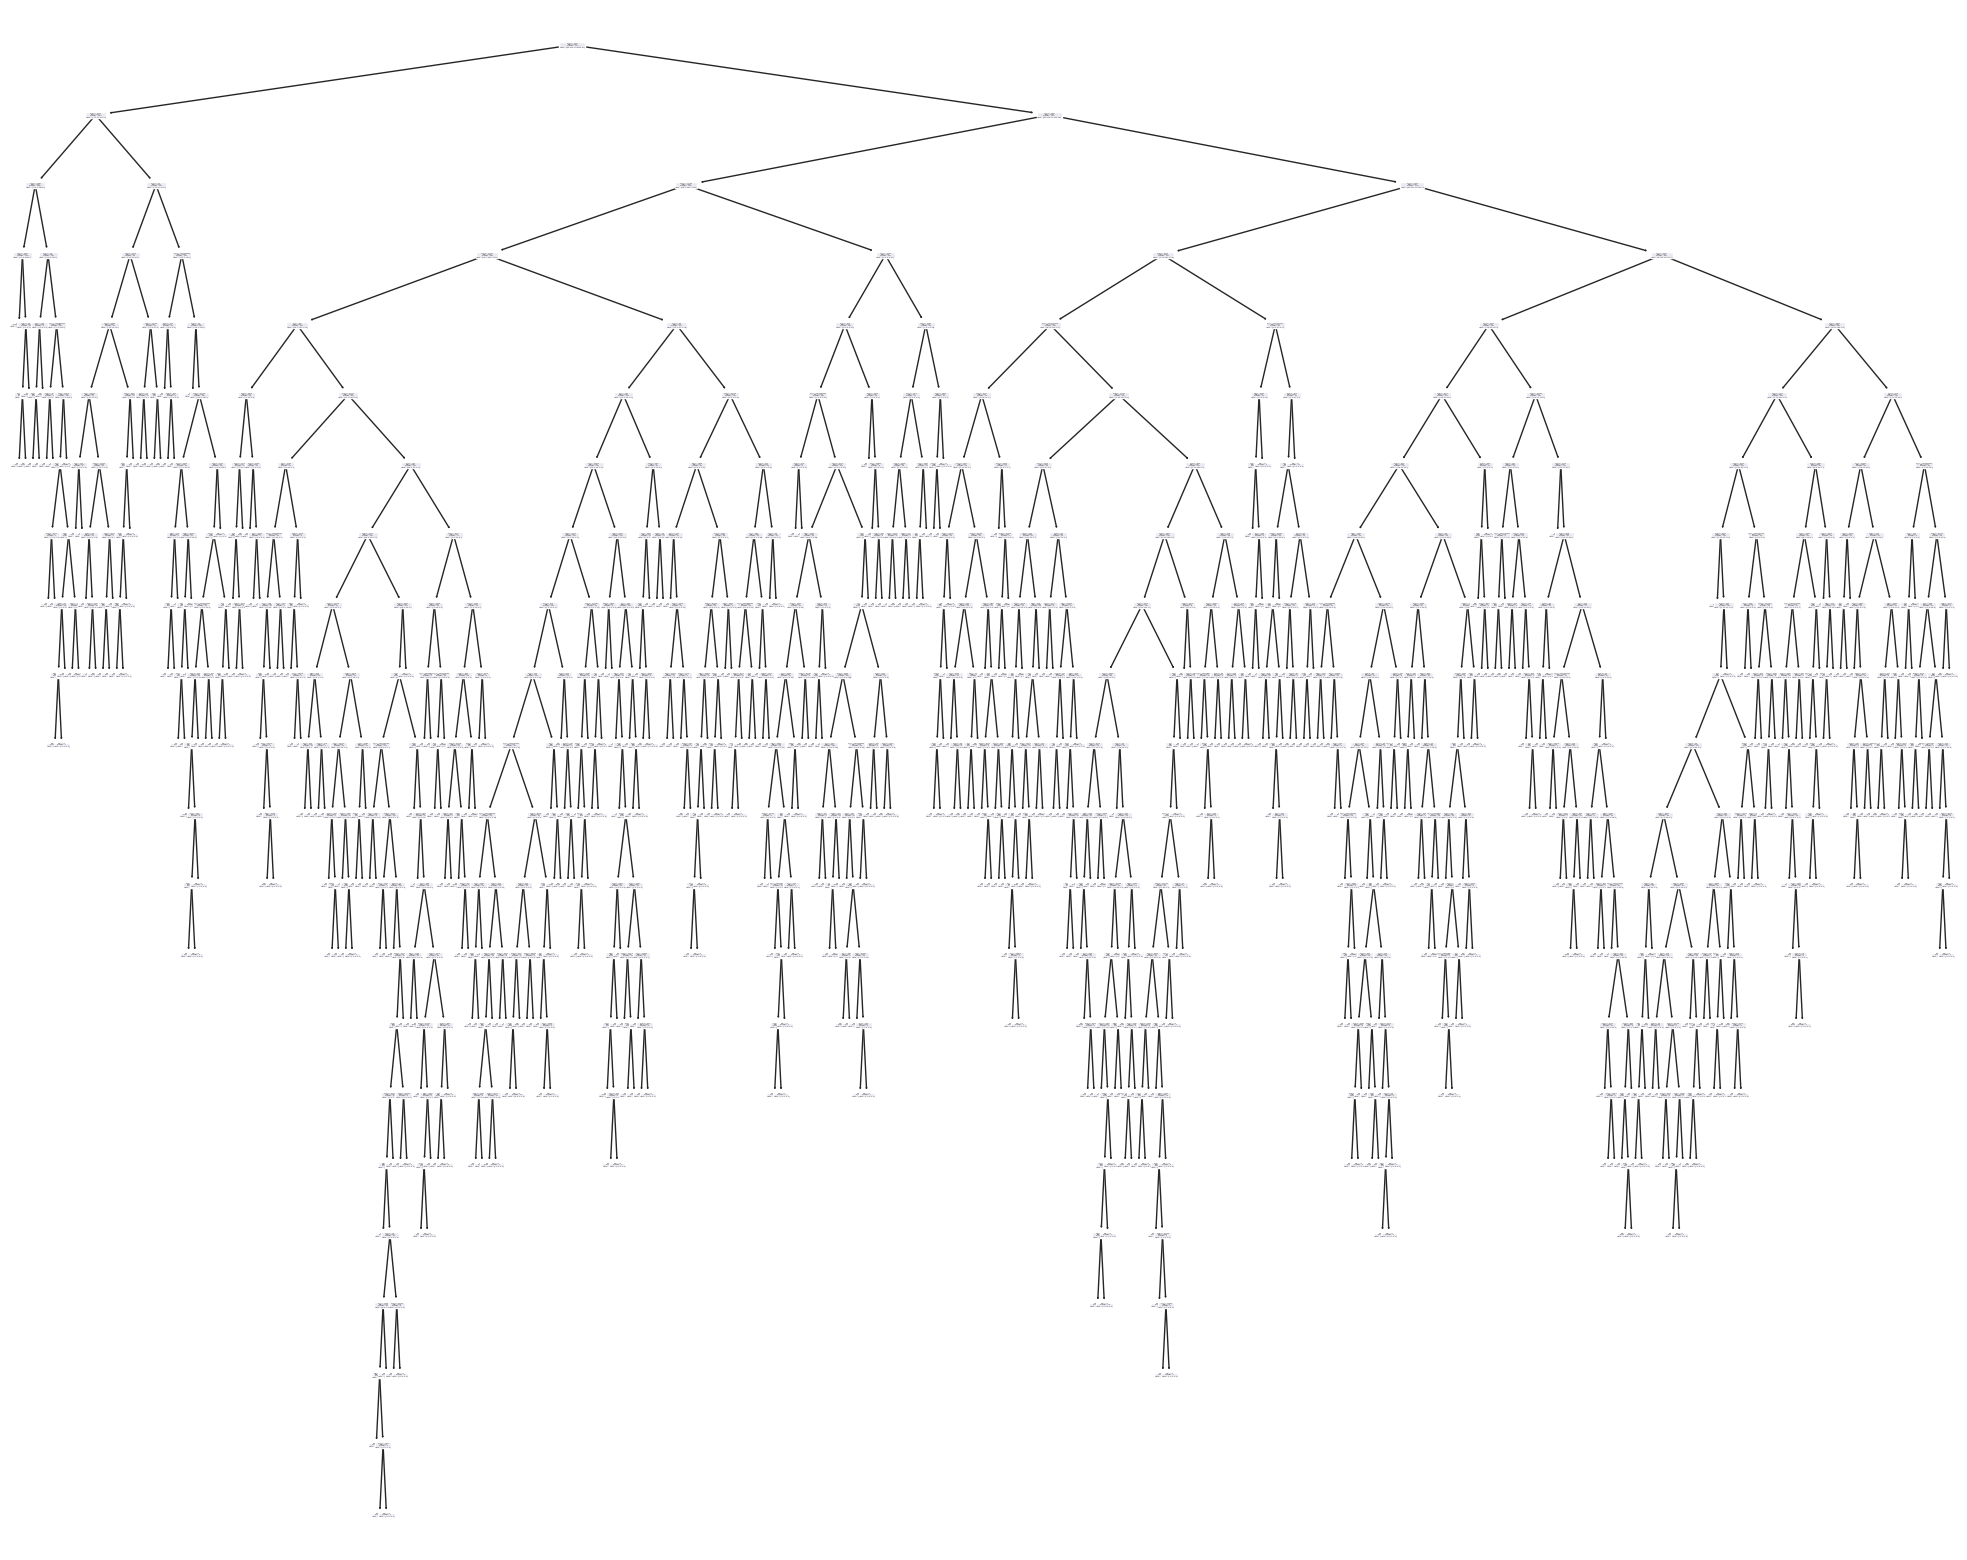

In [102]:
fig = plt.figure(figsize=(25,20))
tree.plot_tree(dt_model)
plt.show()

fig.savefig("dt_plot.png")

In [103]:
text_representation = tree.export_text(dt_model)
print(text_representation)

with open("dt_text.log", "w") as fout:
    fout.write(text_representation)

|--- feature_13 <= 0.17
|   |--- feature_13 <= 0.12
|   |   |--- feature_13 <= 0.09
|   |   |   |--- feature_13 <= 0.06
|   |   |   |   |--- class: 4
|   |   |   |--- feature_13 >  0.06
|   |   |   |   |--- feature_10 <= 0.50
|   |   |   |   |   |--- feature_11 <= 0.09
|   |   |   |   |   |   |--- class: 2
|   |   |   |   |   |--- feature_11 >  0.09
|   |   |   |   |   |   |--- class: 4
|   |   |   |   |--- feature_10 >  0.50
|   |   |   |   |   |--- class: 4
|   |   |--- feature_13 >  0.09
|   |   |   |--- feature_10 <= 0.50
|   |   |   |   |--- feature_0 <= 16.50
|   |   |   |   |   |--- feature_12 <= 0.48
|   |   |   |   |   |   |--- class: 2
|   |   |   |   |   |--- feature_12 >  0.48
|   |   |   |   |   |   |--- class: 4
|   |   |   |   |--- feature_0 >  16.50
|   |   |   |   |   |--- class: 4
|   |   |   |--- feature_10 >  0.50
|   |   |   |   |--- feature_1 <= 1635452992.00
|   |   |   |   |   |--- feature_32 <= 22.50
|   |   |   |   |   |   |--- class: 4
|   |   |   |   |   |--

### Model Evaluation

Now let's get predictions from the model and create a confusion matrix and a classification report.

In [133]:
predictions = dt_model.predict(X_test)

In [134]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score

In [135]:
print("%.3f accuracy" % (accuracy_score(y_test, predictions)))

0.865 accuracy


In [136]:
report = classification_report(y_test, predictions)
print(report)

              precision    recall  f1-score   support

           1       0.64      0.68      0.66       254
           2       0.34      0.30      0.32       112
           3       0.60      0.58      0.59       262
           4       0.97      0.97      0.97      1980
           5       0.72      0.72      0.72       146

    accuracy                           0.87      2754
   macro avg       0.65      0.65      0.65      2754
weighted avg       0.86      0.87      0.86      2754



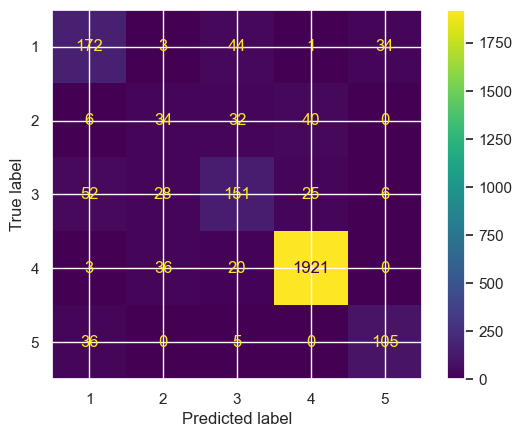

In [137]:
ConfusionMatrixDisplay.from_predictions(y_test,predictions)
plt.show()

### Decision Tree Classifier and Pruning

#### GridSearch

In [138]:
from sklearn.model_selection import GridSearchCV

In [139]:
print(dt_model.get_depth())
print(dt_model.get_n_leaves())

19
619


In [140]:
param_grid_dt = {'criterion': ['gini', 'entropy'], 'max_depth' : [1,2,3,4,5,6,7,8,9,10]}
estimator_dt = DecisionTreeClassifier(random_state=2022)
grid_dt = GridSearchCV(estimator_dt, param_grid_dt, refit=True, verbose=2)

In [141]:
grid_dt.fit(X_train,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END ........................criterion=gini, max_depth=1; total time=   0.0s
[CV] END ........................criterion=gini, max_depth=1; total time=   0.0s
[CV] END ........................criterion=gini, max_depth=1; total time=   0.0s
[CV] END ........................criterion=gini, max_depth=1; total time=   0.0s
[CV] END ........................criterion=gini, max_depth=1; total time=   0.0s
[CV] END ........................criterion=gini, max_depth=2; total time=   0.0s
[CV] END ........................criterion=gini, max_depth=2; total time=   0.0s
[CV] END ........................criterion=gini, max_depth=2; total time=   0.0s
[CV] END ........................criterion=gini, max_depth=2; total time=   0.0s
[CV] END ........................criterion=gini, max_depth=2; total time=   0.0s
[CV] END ........................criterion=gini, max_depth=3; total time=   0.0s
[CV] END ........................criterion=gini

GridSearchCV(estimator=DecisionTreeClassifier(random_state=2022),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
             verbose=2)

In [142]:
grid_dt_score = grid_dt.score(X_test, y_test)
grid_dt_predictions = grid_dt.predict(X_test)
print(classification_report(y_test,grid_dt_predictions))

              precision    recall  f1-score   support

           1       0.66      0.75      0.70       254
           2       0.39      0.25      0.30       112
           3       0.64      0.66      0.65       262
           4       0.97      0.98      0.97      1980
           5       0.78      0.71      0.74       146

    accuracy                           0.88      2754
   macro avg       0.69      0.67      0.67      2754
weighted avg       0.88      0.88      0.88      2754



In [143]:
print('Accuracy: %.3f%%' % (grid_dt_score * 100))

Accuracy: 88.163%


In [144]:
results = {'DTGridSearchCV': grid_dt_score}

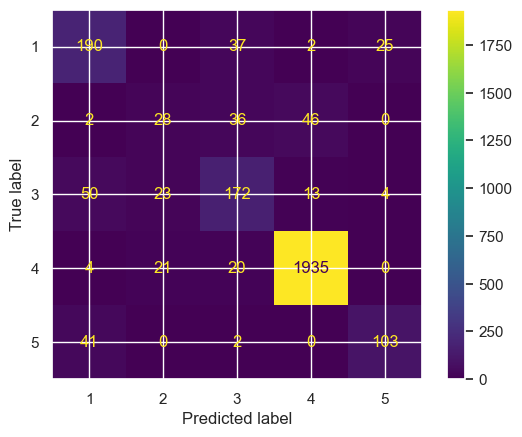

In [145]:
ConfusionMatrixDisplay.from_predictions(y_test, grid_dt_predictions)
plt.show()

##### Best Depth Tree

In [146]:
max_depth = dt_model.get_depth()
max_depth

19

In [147]:
param_grid = {'max_depth': [max_depth for max_depth in range(1, max_depth + 1)]}

In [148]:
estimator = DecisionTreeClassifier(random_state=203)

In [149]:
max_depth_grid_search = GridSearchCV(estimator, param_grid)

In [150]:
max_depth_grid_search.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=203),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19]})

In [151]:
max_depth_grid_search.best_params_

{'max_depth': 7}

In [152]:
max_depth_tree = max_depth_grid_search.best_estimator_
print(max_depth_tree)

DecisionTreeClassifier(max_depth=7, random_state=203)


In [153]:
best_max_depth = max_depth_tree.get_depth()
print(best_max_depth)

7


In [154]:
max_depth_grid_search_score = max_depth_grid_search.score(X_test, y_test)
max_depth_grid_search_predictions = max_depth_grid_search.predict(X_test)
print(classification_report(y_test,max_depth_grid_search_predictions))

              precision    recall  f1-score   support

           1       0.67      0.75      0.71       254
           2       0.39      0.25      0.31       112
           3       0.64      0.66      0.65       262
           4       0.97      0.98      0.97      1980
           5       0.79      0.71      0.75       146

    accuracy                           0.88      2754
   macro avg       0.69      0.67      0.68      2754
weighted avg       0.88      0.88      0.88      2754



In [155]:
print('Accuracy: %.3f%%' % (max_depth_grid_search_score * 100))

Accuracy: 88.272%


In [156]:
results['Max_Depth'] = max_depth_grid_search_score

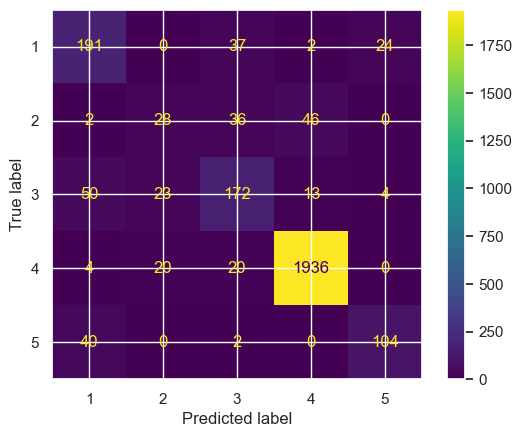

In [157]:
ConfusionMatrixDisplay.from_predictions(y_test, max_depth_grid_search_predictions)
plt.show()

#### Cost Complexity Pruning

In [158]:
ccp_alphas = dt_model.cost_complexity_pruning_path(X_train, y_train)["ccp_alphas"]
ccp_alphas

array([0.00000000e+00, 1.07587617e-04, 1.08932462e-04, 1.10949730e-04,
       1.10949730e-04, 1.11725602e-04, 1.12966997e-04, 1.13471314e-04,
       1.13916300e-04, 1.14311843e-04, 1.14665749e-04, 1.14665749e-04,
       1.14984265e-04, 1.14984265e-04, 1.14984265e-04, 1.14984265e-04,
       1.15272446e-04, 1.15272446e-04, 1.15272446e-04, 1.16194626e-04,
       1.16258329e-04, 1.16553251e-04, 1.17932580e-04, 1.18010167e-04,
       1.18615347e-04, 1.18893837e-04, 1.19018801e-04, 1.20139505e-04,
       1.21036069e-04, 1.21036069e-04, 1.21036069e-04, 1.21036069e-04,
       1.21036069e-04, 1.21036069e-04, 1.21036069e-04, 1.21036069e-04,
       1.21036069e-04, 1.21036069e-04, 1.21036069e-04, 1.21036069e-04,
       1.21036069e-04, 1.21036069e-04, 1.21036069e-04, 1.21036069e-04,
       1.21036069e-04, 1.21036069e-04, 1.21036069e-04, 1.21036069e-04,
       1.21036069e-04, 1.21036069e-04, 1.21036069e-04, 1.21036069e-04,
       1.21036069e-04, 1.45243282e-04, 1.45243282e-04, 1.50251672e-04,
      

In [159]:
estimator.get_params().keys()

dict_keys(['ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'random_state', 'splitter'])

In [160]:
param_grid = {'ccp_alpha': [alpha for alpha in ccp_alphas]}

In [161]:
estimator_dt = DecisionTreeClassifier(random_state=28)
ccp_alpha_grid_search = GridSearchCV(estimator_dt, param_grid)

In [162]:
ccp_alpha_grid_search.fit(X_train,y_train)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=28),
             param_grid={'ccp_alpha': [0.0, 0.00010758761666532182,
                                       0.00010893246187363833,
                                       0.00011094972968611314,
                                       0.00011094972968611314,
                                       0.00011172560192168031,
                                       0.00011296699749858794,
                                       0.00011347131445170662,
                                       0.00011391629999857607,
                                       0.00011431184270690446,
                                       0.000114665749340672,
                                       0.000114665749340672,
                                       0.0001149...
                                       0.00011498426531106267,
                                       0.00011527244642713056,
                                       0.00011527244642713056,
                                       0.00011527244642713058,
                                       0.00011619462599854753,
                                       0.00011625832919262575,
                                       0.00011655325138743193,
                                       0.00011793257980621806,
                                       0.00011801016702977478,
                                       0.00011861534737351735,
                                       0.00011889383744320422,
                                       0.00011901880093601233,
                                       0.00012013950527627638,
                                       0.00012103606874848704,
                                       0.00012103606874848704, ...]})

In [163]:
ccp_alpha_grid_search.best_params_

{'ccp_alpha': 0.0005156746794578396}

In [164]:
best_ccp_alpha_tree = ccp_alpha_grid_search.best_estimator_
print(best_ccp_alpha_tree)

DecisionTreeClassifier(ccp_alpha=0.0005156746794578396, random_state=28)


In [165]:
ccp_alpha_grid_search_score = ccp_alpha_grid_search.score(X_test, y_test)
ccp_alpha_grid_search_predictions = ccp_alpha_grid_search.predict(X_test)
print(classification_report(y_test,ccp_alpha_grid_search_predictions))

              precision    recall  f1-score   support

           1       0.68      0.75      0.71       254
           2       0.40      0.26      0.32       112
           3       0.65      0.65      0.65       262
           4       0.97      0.98      0.97      1980
           5       0.78      0.74      0.76       146

    accuracy                           0.88      2754
   macro avg       0.70      0.68      0.68      2754
weighted avg       0.88      0.88      0.88      2754



In [166]:
print('Accuracy: %.3f%%' % (ccp_alpha_grid_search_score * 100))

Accuracy: 88.489%


In [167]:
results['ccp_alpha_grid'] = ccp_alpha_grid_search_score

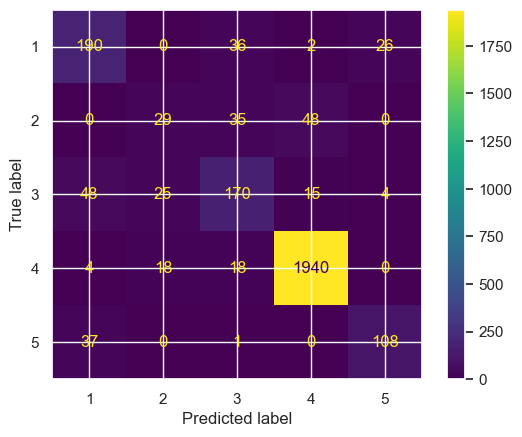

In [168]:
ConfusionMatrixDisplay.from_predictions(y_test, ccp_alpha_grid_search_predictions)
plt.show()

### Bagging (Boostrap Aggregating)

In [169]:
sss = StratifiedShuffleSplit(n_splits = 10, test_size = 20, random_state = 2023)

In [170]:
bg_model = BaggingClassifier(estimator = dt_model, bootstrap= True)

In [171]:
n_estimators = [10, 40, 60, 80, 100, 160]

In [172]:
parameters = {'n_estimators': n_estimators}

In [173]:
grid_bg = GridSearchCV(estimator= bg_model, param_grid= parameters, cv = sss)

In [174]:
grid_bg.fit(X_train, y_train)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=2023, test_size=20,
            train_size=None),
             estimator=BaggingClassifier(estimator=DecisionTreeClassifier(random_state=2023)),
             param_grid={'n_estimators': [10, 40, 60, 80, 100, 160]})

In [175]:
grid_bg_score = grid_bg.score(X_test, y_test)

In [176]:
print("Accuracy: %.3f%%" % (grid_bg_score*100))

Accuracy: 89.833%


In [177]:
grid_bg_predictions = grid_bg.predict(X_test)
print(classification_report(y_test, grid_bg_predictions))

              precision    recall  f1-score   support

           1       0.74      0.80      0.77       254
           2       0.42      0.25      0.31       112
           3       0.69      0.69      0.69       262
           4       0.97      0.98      0.97      1980
           5       0.86      0.84      0.85       146

    accuracy                           0.90      2754
   macro avg       0.73      0.71      0.72      2754
weighted avg       0.89      0.90      0.89      2754



In [178]:
results['Bagg'] = grid_bg_score

### Random Forest

In [179]:
rf_model = RandomForestClassifier(bootstrap= False, max_depth = 20, verbose = 1)

In [180]:
rf_model.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.5s


RandomForestClassifier(bootstrap=False, max_depth=20, verbose=1)

In [181]:
rf_score = rf_model.score(X_test, y_test)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


In [182]:
print("Accuracy: %.3f%%" % (rf_score*100))

Accuracy: 88.526%


In [183]:
rf_predictions = rf_model.predict(X_test)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


In [184]:
print(classification_report(y_test, rf_predictions))

              precision    recall  f1-score   support

           1       0.72      0.76      0.74       254
           2       0.39      0.18      0.25       112
           3       0.61      0.69      0.65       262
           4       0.97      0.97      0.97      1980
           5       0.83      0.82      0.82       146

    accuracy                           0.89      2754
   macro avg       0.70      0.68      0.68      2754
weighted avg       0.88      0.89      0.88      2754



In [185]:
results['RF'] = rf_score

### Boosting
#### Gradient Boosting

In [203]:
gbc_model = GradientBoostingClassifier(n_estimators= 100, learning_rate= 1.0, max_depth= 3, random_state= 2024)

In [204]:
gbc_model.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=1.0, random_state=2024)

In [205]:
gbc_score = gbc_model.score(X_test, y_test)
print("Accuracy: %.3f%%" % (gbc_score*100))

Accuracy: 84.459%


In [208]:
gbc_predictions = gbc_model.predict(X_test)
print(classification_report(y_test, gbc_predictions))

              precision    recall  f1-score   support

           1       0.56      0.66      0.61       254
           2       0.28      0.26      0.27       112
           3       0.58      0.58      0.58       262
           4       0.96      0.97      0.97      1980
           5       0.56      0.32      0.40       146

    accuracy                           0.84      2754
   macro avg       0.59      0.56      0.57      2754
weighted avg       0.84      0.84      0.84      2754



In [209]:
results['GB'] = gbc_score

### Stacking

In [210]:
estimators = [("dt", dt_model), ("rf", rf_model)]

In [211]:
st_model = StackingClassifier(estimators=estimators, final_estimator= LogisticRegression())

In [212]:
st_model.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


StackingClassifier(estimators=[('dt',
                                DecisionTreeClassifier(random_state=2023)),
                               ('rf',
                                RandomForestClassifier(bootstrap=False,
                                                       max_depth=20,
                                                       verbose=1))],
                   final_estimator=LogisticRegression())

In [213]:
st_score = st_model.score(X_test, y_test)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


In [214]:
print("Accuraçy: %.3f%%" % (st_score*100))

Accuraçy: 89.034%


In [215]:
st_predictions =st_model.predict(X_test)
print(classification_report(y_test, st_predictions))

              precision    recall  f1-score   support

           1       0.72      0.78      0.75       254
           2       0.47      0.21      0.29       112
           3       0.62      0.69      0.65       262
           4       0.97      0.98      0.97      1980
           5       0.86      0.78      0.82       146

    accuracy                           0.89      2754
   macro avg       0.73      0.69      0.70      2754
weighted avg       0.88      0.89      0.88      2754



[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


In [216]:
results['Stack'] = st_score

### MAX voting

In [217]:
hvt_model = VotingClassifier(estimators = [("dt", dt_model), ("rf", rf_model)],
                             voting = 'hard', weights=[2,2])

In [218]:
hvt_model.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.5s


VotingClassifier(estimators=[('dt', DecisionTreeClassifier(random_state=2023)),
                             ('rf',
                              RandomForestClassifier(bootstrap=False,
                                                     max_depth=20,
                                                     verbose=1))],
                 weights=[2, 2])

In [219]:
for model, label in zip([dt_model, rf_model, hvt_model],['dt','rf','Ensemble']):
    hvt_score = cross_val_score(model, X_test, y_test, scoring= 'accuracy', cv = 5)
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (hvt_score.mean(), hvt_score.std(), label))

Accuracy: 0.84 (+/- 0.01) [dt]


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Accuracy: 0.86 (+/- 0.01) [rf]


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.3s


Accuracy: 0.85 (+/- 0.01) [Ensemble]


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


In [220]:
hvt_score = hvt_model.score(X_test, y_test)
print("Accuracy: %.3f%%" % (hvt_score*100))

Accuracy: 87.073%


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


In [221]:
hvt_predictions = hvt_model.predict(X_test)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


In [222]:
print(classification_report(y_test, hvt_predictions))

              precision    recall  f1-score   support

           1       0.62      0.85      0.71       254
           2       0.35      0.38      0.36       112
           3       0.62      0.55      0.59       262
           4       0.98      0.96      0.97      1980
           5       0.87      0.65      0.75       146

    accuracy                           0.87      2754
   macro avg       0.69      0.68      0.68      2754
weighted avg       0.88      0.87      0.87      2754



In [223]:
results['HVotW'] = hvt_score

## Neural Network

In [224]:
scaler_X = MinMaxScaler(feature_range=(0, 1)).fit(X)
X_scaled = pd.DataFrame(scaler_X.transform(X[X.columns]), columns=X.columns)

In [225]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=2022)

In [226]:
from keras import regularizers
from tensorflow import keras

optimizer = keras.optimizers.Adam(learning_rate=0.001)


def build_model():
    model = keras.Sequential()

    model.add(Dense(16, input_dim=12, activation='relu',
                    kernel_regularizer=regularizers.l2(0.001),
                    ))  # Input Layer

    model.add(Dense(8, activation="relu",
                    kernel_regularizer=regularizers.l2(0.001),
                    ))

    model.add(Dense(5, activation='softmax',
                    kernel_regularizer=regularizers.l2(0.001),
                    ))  # Output Layer

    # Model compilation
    model.compile(loss=SparseCategoricalCrossentropy(), optimizer=optimizer,
                  #keras.optimizers.Adam(learning_rate=0.001),
                  metrics=['accuracy'])

    return model

In [227]:
model = build_model()

In [228]:
y_train = y_train.astype(int)
y_train = np.clip(y_train, 0, 4)
y_train[np.isnan(y_train)] = 0

In [229]:
history = model.fit(X_train, y_train, epochs=500, batch_size=100)

Epoch 1/500
89/89 [==============================] - 3s 1ms/step - loss: 1.1693 - accuracy: 0.6490
Epoch 2/500
89/89 [==============================] - 0s 1ms/step - loss: 0.6318 - accuracy: 0.7607
Epoch 3/500
89/89 [==============================] - 0s 2ms/step - loss: 0.5579 - accuracy: 0.7607
Epoch 4/500
89/89 [==============================] - 0s 1ms/step - loss: 0.5283 - accuracy: 0.7608
Epoch 5/500
89/89 [==============================] - 0s 1ms/step - loss: 0.5078 - accuracy: 0.7634
Epoch 6/500
89/89 [==============================] - 0s 1ms/step - loss: 0.4929 - accuracy: 0.7713
Epoch 7/500
89/89 [==============================] - 0s 1ms/step - loss: 0.4768 - accuracy: 0.7943
Epoch 8/500
89/89 [==============================] - 0s 2ms/step - loss: 0.4596 - accuracy: 0.8054
Epoch 9/500
89/89 [==============================] - 0s 1ms/step - loss: 0.4448 - accuracy: 0.8187
Epoch 10/500
89/89 [==============================] - 0s 1ms/step - loss: 0.4321 - accuracy: 0.8219
Epoch 11/

In [230]:
# Convert to integers
y_test = y_test.astype(int)

# Ensure labels are within the valid range
y_test = np.clip(y_test, 0, 4)

In [231]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)

69/69 [==============================] - 3s 948us/step - loss: 0.3358 - accuracy: 0.8593


In [232]:
predicts = model.predict(X_test)

categories_predicted = [np.argmax(pred) for pred in predicts]

69/69 [==============================] - 3s 847us/step


In [233]:
predicts[:5]

array([[8.8482324e-15, 2.6172376e-04, 5.7873791e-01, 1.7236823e-01,
        2.4863212e-01],
       [6.6333546e-34, 6.7823376e-30, 6.1878759e-11, 2.7257283e-14,
        1.0000000e+00],
       [0.0000000e+00, 3.0459413e-33, 2.3801684e-17, 1.0920264e-16,
        1.0000000e+00],
       [7.9670629e-18, 1.1557043e-09, 5.2227008e-01, 3.1923171e-02,
        4.4580680e-01],
       [4.0119919e-19, 6.0020960e-07, 1.5964468e-01, 4.0181533e-02,
        8.0017322e-01]], dtype=float32)

In [234]:
categories_predicted

[2,
 4,
 4,
 2,
 4,
 3,
 1,
 4,
 4,
 4,
 1,
 4,
 1,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 1,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 1,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 3,
 4,
 1,
 4,
 4,
 4,
 3,
 3,
 4,
 4,
 4,
 1,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 1,
 4,
 4,
 4,
 4,
 4,
 2,
 4,
 4,
 3,
 1,
 4,
 1,
 4,
 4,
 4,
 3,
 1,
 4,
 4,
 4,
 4,
 4,
 4,
 2,
 4,
 4,
 3,
 1,
 3,
 4,
 4,
 4,
 3,
 4,
 3,
 4,
 4,
 4,
 4,
 3,
 3,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 3,
 4,
 4,
 4,
 4,
 4,
 1,
 4,
 4,
 4,
 4,
 4,
 4,
 1,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 1,
 4,
 4,
 3,
 1,
 4,
 4,
 3,
 4,
 3,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 3,
 4,
 3,
 4,
 4,
 1,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 1,
 4,
 3,
 4,
 2,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 3,
 3,
 4,
 3,
 4,
 4,
 4,
 2,
 4,
 4,
 4,
 4,
 3,
 4,
 4,
 1,
 4,
 4,
 1,
 4,
 4,
 1,
 4,
 4,
 4,
 4,
 4,
 1,
 4,
 1,
 4,
 4,
 1,
 4,
 4,
 4,
 3,
 4,
 4,
 4,
 4,
 2,
 4,
 4,
 4,
 4,
 4,
 3,
 4,
 2,
 4,


In [235]:
y_test

3370     4
7747     4
9881     4
2024     4
3848     3
        ..
2924     4
3388     4
8043     4
10629    4
2036     4
Name: Injeção na rede (kWh), Length: 2204, dtype: int32

In [236]:
print("Accuracy: %.3f%%" % (accuracy*100))

Accuracy: 85.935%


In [237]:
results['Neural Network'] = accuracy

## Models Accuracy Comparison

<function matplotlib.pyplot.show(close=None, block=None)>

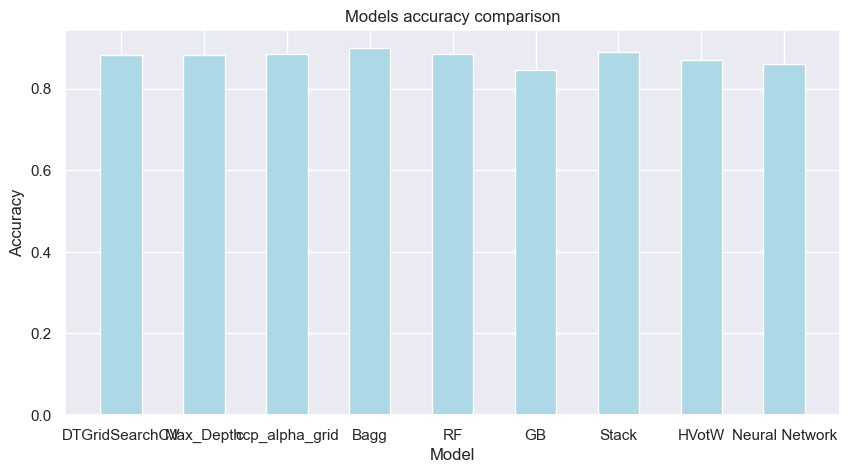

In [238]:
fig = plt.figure(figsize = (10, 5))

mod = list(results.keys())
acc = list(results.values())

plt.bar(mod, acc, color = 'lightblue',
       width= 0.5)

plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Models accuracy comparison")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

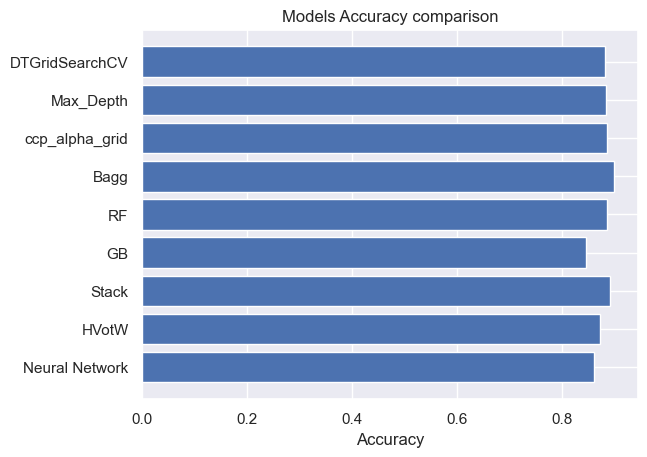

In [239]:
fig, ax = plt.subplots()

y_values = np.arange(len(mod))

ax.barh(y_values, acc, align='center')
ax.set_yticks(y_values, labels = mod)
ax.invert_yaxis()
ax.set_xlabel('Accuracy')
ax.set_title('Models Accuracy comparison')

plt.show

In [240]:
print('Models accuracy comparison')
for key, value in results.items():
    print("%s \t %.3f%%" % (key, value))

Models accuracy comparison
DTGridSearchCV 	 0.882%
Max_Depth 	 0.883%
ccp_alpha_grid 	 0.885%
Bagg 	 0.898%
RF 	 0.885%
GB 	 0.845%
Stack 	 0.890%
HVotW 	 0.871%
Neural Network 	 0.859%


### Resumindo o que foi feito:

Basicamente dos treinos todos feitos, o tuning (qualquer um) melhorou +-0,2 o que é ótimo (quanto a mais casas décimais não sabemos, daí vamos ter que ir experimentar as 3 submissões dos 3 tunings que dão 0.86 e ver qual o maior accuracy na submissão), agora precisamos de voltar a pôr os dados normais (em None, Low, etc) e pôr no submissions.

Para já isto foi o melhor que consegui, mas tenho mais ideias para usar, nomeadamente aplicar xboost (o xboost nunca chegamos a fazer, mas um gajo inventa e consegue chegar lá) e gradient boosting regressor

##### ATUALIZAÇÃO:
Estão os modelos "todos feitos". Supostamente, segundo outros colegas, o random forest é o que costuma dar melhor resultado. No nosso caso não é, não entendo porquê, mas a nós o melhor que consegui foi do Bagging(Bootstrap Aggregating) aka Bagg, com 0.873. Quanto ao XGB, ele dá erro caso não tenha os valores a começar por 0, na Injeção de Rede. Eu troquei e cagou o modelo todo, não sei se realmente existe alguma forma consistente para que não dê 0.025%.
De resto, tentem então rever tudo e o Random_Forest principalmente por ser o melhor quanto aos outros, e no nosso caso não o ser (weirdly).

## Previsão dos dados de 2023

In [241]:
assert df3['date'].isnull().sum() == 0, 'missing record rate'
df3['date_year'] = df3['date'].dt.year
df3['date_month'] = df3['date'].dt.month
df3['date_day'] = df3['date'].dt.day

In [242]:
labels = df3['Injeção na rede (kWh)'].astype('category').cat.categories.tolist()
replace_map_comp = {'Injeção na rede (kWh)' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}
print(replace_map_comp)

{'Injeção na rede (kWh)': {'None': 1}}


In [243]:
df3.replace(replace_map_comp, inplace=True)
df3

,date,hour,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),dt,temp,feels_like,temp_min,temp_max,...,direct_normal_irradiance (W/m²),terrestrial_radiation (W/m²),shortwave_radiation_instant (W/m²),direct_radiation_instant (W/m²),diffuse_radiation_instant (W/m²),direct_normal_irradiance_instant (W/m²),terrestrial_radiation_instant (W/m²),date_year,date_month,date_day
0,2023-01-01,0,0.000,0.467,0.000,1.672531e+09,12.93,12.76,12.72,13.43,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023,1,1
1,2023-01-01,1,0.000,0.577,0.000,1.672535e+09,13.49,13.38,13.43,13.90,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023,1,1
2,2023-01-01,2,0.000,0.346,0.000,1.672538e+09,13.55,13.44,13.48,14.82,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023,1,1
3,2023-01-01,3,0.000,0.270,0.000,1.672542e+09,13.61,13.51,12.01,14.82,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023,1,1
4,2023-01-01,4,0.000,0.252,0.000,1.672546e+09,13.59,13.49,12.01,14.82,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2251,2023-04-04,19,0.953,0.000,0.012,0.000000e+00,20.10,18.10,5.70,22.00,...,270.4,121.7,0.0,0.0,0.0,0.0,0.0,2023,4,4
2252,2023-04-04,20,0.915,0.000,0.000,0.000000e+00,13.60,11.50,5.70,22.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023,4,4
2253,2023-04-04,21,0.479,0.000,0.000,0.000000e+00,12.60,10.60,5.70,22.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023,4,4
2254,2023-04-04,22,0.000,0.497,0.000,0.000000e+00,11.70,9.50,5.70,22.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023,4,4


In [244]:
value_counts = df3['Injeção na rede (kWh)'].value_counts(dropna=False)
print(value_counts)

Injeção na rede (kWh)
1    2256
Name: count, dtype: int64


In [245]:
df3.drop('date',axis=1,inplace=True)
df3

,hour,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),dt,temp,feels_like,temp_min,temp_max,pressure,...,direct_normal_irradiance (W/m²),terrestrial_radiation (W/m²),shortwave_radiation_instant (W/m²),direct_radiation_instant (W/m²),diffuse_radiation_instant (W/m²),direct_normal_irradiance_instant (W/m²),terrestrial_radiation_instant (W/m²),date_year,date_month,date_day
0,0,0.000,0.467,0.000,1.672531e+09,12.93,12.76,12.72,13.43,1019.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023,1,1
1,1,0.000,0.577,0.000,1.672535e+09,13.49,13.38,13.43,13.90,1018.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023,1,1
2,2,0.000,0.346,0.000,1.672538e+09,13.55,13.44,13.48,14.82,1017.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023,1,1
3,3,0.000,0.270,0.000,1.672542e+09,13.61,13.51,12.01,14.82,1016.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023,1,1
4,4,0.000,0.252,0.000,1.672546e+09,13.59,13.49,12.01,14.82,1015.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2251,19,0.953,0.000,0.012,0.000000e+00,20.10,18.10,5.70,22.00,992.6,...,270.4,121.7,0.0,0.0,0.0,0.0,0.0,2023,4,4
2252,20,0.915,0.000,0.000,0.000000e+00,13.60,11.50,5.70,22.00,993.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023,4,4
2253,21,0.479,0.000,0.000,0.000000e+00,12.60,10.60,5.70,22.00,993.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023,4,4
2254,22,0.000,0.497,0.000,0.000000e+00,11.70,9.50,5.70,22.00,994.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023,4,4


In [246]:
X_2023 = df3.drop(['Injeção na rede (kWh)'], axis=1)
feature_order = X_train.columns.tolist()
X_2023_reordered = X_2023[feature_order]

### Modelo Bagging

In [247]:
predictions_2023 = grid_bg.predict(X_2023_reordered)
df3['Injeção na rede (kWh)'] = predictions_2023
df3

,hour,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),dt,temp,feels_like,temp_min,temp_max,pressure,...,direct_normal_irradiance (W/m²),terrestrial_radiation (W/m²),shortwave_radiation_instant (W/m²),direct_radiation_instant (W/m²),diffuse_radiation_instant (W/m²),direct_normal_irradiance_instant (W/m²),terrestrial_radiation_instant (W/m²),date_year,date_month,date_day
0,0,0.000,0.467,0.000,1.672531e+09,12.93,12.76,12.72,13.43,1019.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023,1,1
1,1,0.000,0.577,0.000,1.672535e+09,13.49,13.38,13.43,13.90,1018.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023,1,1
2,2,0.000,0.346,0.000,1.672538e+09,13.55,13.44,13.48,14.82,1017.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023,1,1
3,3,0.000,0.270,0.000,1.672542e+09,13.61,13.51,12.01,14.82,1016.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023,1,1
4,4,0.000,0.252,0.000,1.672546e+09,13.59,13.49,12.01,14.82,1015.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2251,19,0.953,0.000,0.012,0.000000e+00,20.10,18.10,5.70,22.00,992.6,...,270.4,121.7,0.0,0.0,0.0,0.0,0.0,2023,4,4
2252,20,0.915,0.000,0.000,0.000000e+00,13.60,11.50,5.70,22.00,993.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023,4,4
2253,21,0.479,0.000,0.000,0.000000e+00,12.60,10.60,5.70,22.00,993.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023,4,4
2254,22,0.000,0.497,0.000,0.000000e+00,11.70,9.50,5.70,22.00,994.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023,4,4


In [248]:
value_counts = df3['Injeção na rede (kWh)'].value_counts(dropna=False)
print(value_counts)

Injeção na rede (kWh)
4    1641
1     253
3     247
2      76
5      39
Name: count, dtype: int64


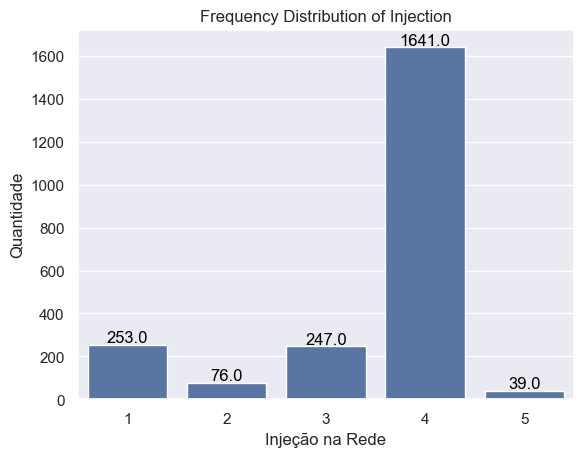

In [249]:
import seaborn as sns
import matplotlib.pyplot as plt

injecao_count = df3['Injeção na rede (kWh)'].value_counts()
sns.set(style='darkgrid')
barplot = sns.barplot(x=injecao_count.index, y=injecao_count.values)

for p in barplot.patches:
    barplot.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                     textcoords='offset points')

plt.title('Frequency Distribution of Injection')
plt.ylabel('Quantidade', fontsize=12)
plt.xlabel('Injeção na Rede', fontsize=12)
plt.show()

### Modelo Random Forest

In [250]:
predictions_2023 = rf_model.predict(X_2023_reordered)
df3['Injeção na rede (kWh)'] = predictions_2023
df3

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


,hour,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),dt,temp,feels_like,temp_min,temp_max,pressure,...,direct_normal_irradiance (W/m²),terrestrial_radiation (W/m²),shortwave_radiation_instant (W/m²),direct_radiation_instant (W/m²),diffuse_radiation_instant (W/m²),direct_normal_irradiance_instant (W/m²),terrestrial_radiation_instant (W/m²),date_year,date_month,date_day
0,0,0.000,0.467,0.000,1.672531e+09,12.93,12.76,12.72,13.43,1019.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023,1,1
1,1,0.000,0.577,0.000,1.672535e+09,13.49,13.38,13.43,13.90,1018.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023,1,1
2,2,0.000,0.346,0.000,1.672538e+09,13.55,13.44,13.48,14.82,1017.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023,1,1
3,3,0.000,0.270,0.000,1.672542e+09,13.61,13.51,12.01,14.82,1016.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023,1,1
4,4,0.000,0.252,0.000,1.672546e+09,13.59,13.49,12.01,14.82,1015.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2251,19,0.953,0.000,0.012,0.000000e+00,20.10,18.10,5.70,22.00,992.6,...,270.4,121.7,0.0,0.0,0.0,0.0,0.0,2023,4,4
2252,20,0.915,0.000,0.000,0.000000e+00,13.60,11.50,5.70,22.00,993.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023,4,4
2253,21,0.479,0.000,0.000,0.000000e+00,12.60,10.60,5.70,22.00,993.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023,4,4
2254,22,0.000,0.497,0.000,0.000000e+00,11.70,9.50,5.70,22.00,994.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023,4,4


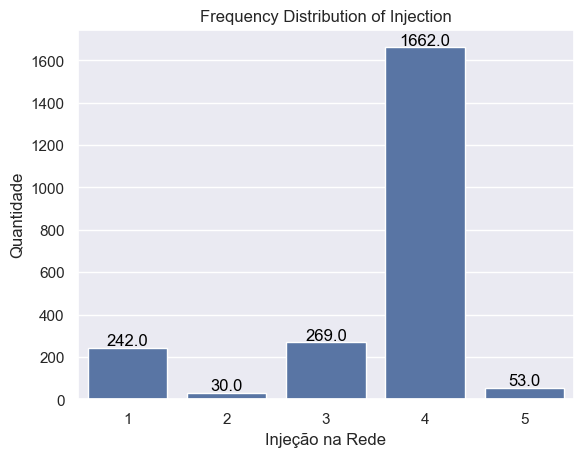

In [251]:
injecao_count = df3['Injeção na rede (kWh)'].value_counts()
sns.set(style='darkgrid')
barplot = sns.barplot(x=injecao_count.index, y=injecao_count.values)

for p in barplot.patches:
    barplot.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                     textcoords='offset points')

plt.title('Frequency Distribution of Injection')
plt.ylabel('Quantidade', fontsize=12)
plt.xlabel('Injeção na Rede', fontsize=12)

plt.show()

### Modelo Neural Network

In [252]:
X_test_scaled = pd.DataFrame(scaler_X.transform(X_2023_reordered[X_2023_reordered.columns]), columns=X_2023_reordered.columns)

predictions = model.predict(X_test_scaled)

predicted_labels = np.argmax(predictions, axis=1)

71/71 [==============================] - 2s 879us/step


In [253]:
predictions

array([[0.0000000e+00, 0.0000000e+00, 3.3061789e-30, 5.3291572e-26,
        1.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 2.6718836e-31, 4.0695140e-28,
        1.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 2.3714117e-26, 1.5429395e-22,
        1.0000000e+00],
       ...,
       [0.0000000e+00, 0.0000000e+00, 1.9592373e-35, 0.0000000e+00,
        1.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 5.9069321e-38, 0.0000000e+00,
        1.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 7.5730866e-38, 0.0000000e+00,
        1.0000000e+00]], dtype=float32)

In [254]:
df3['Injeção na rede (kWh)'] = predicted_labels
df3

,hour,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),dt,temp,feels_like,temp_min,temp_max,pressure,...,direct_normal_irradiance (W/m²),terrestrial_radiation (W/m²),shortwave_radiation_instant (W/m²),direct_radiation_instant (W/m²),diffuse_radiation_instant (W/m²),direct_normal_irradiance_instant (W/m²),terrestrial_radiation_instant (W/m²),date_year,date_month,date_day
0,0,0.000,0.467,0.000,1.672531e+09,12.93,12.76,12.72,13.43,1019.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023,1,1
1,1,0.000,0.577,0.000,1.672535e+09,13.49,13.38,13.43,13.90,1018.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023,1,1
2,2,0.000,0.346,0.000,1.672538e+09,13.55,13.44,13.48,14.82,1017.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023,1,1
3,3,0.000,0.270,0.000,1.672542e+09,13.61,13.51,12.01,14.82,1016.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023,1,1
4,4,0.000,0.252,0.000,1.672546e+09,13.59,13.49,12.01,14.82,1015.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2251,19,0.953,0.000,0.012,0.000000e+00,20.10,18.10,5.70,22.00,992.6,...,270.4,121.7,0.0,0.0,0.0,0.0,0.0,2023,4,4
2252,20,0.915,0.000,0.000,0.000000e+00,13.60,11.50,5.70,22.00,993.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023,4,4
2253,21,0.479,0.000,0.000,0.000000e+00,12.60,10.60,5.70,22.00,993.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023,4,4
2254,22,0.000,0.497,0.000,0.000000e+00,11.70,9.50,5.70,22.00,994.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023,4,4


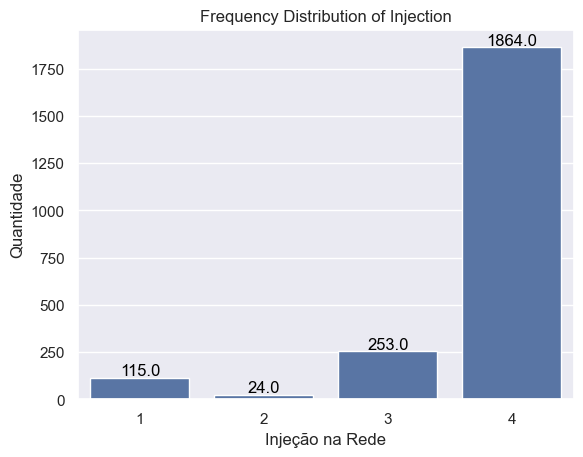

In [255]:
injecao_count = df3['Injeção na rede (kWh)'].value_counts()
sns.set(style='darkgrid')
barplot = sns.barplot(x=injecao_count.index, y=injecao_count.values)

for p in barplot.patches:
    barplot.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                     textcoords='offset points')

plt.title('Frequency Distribution of Injection')
plt.ylabel('Quantidade', fontsize=12)
plt.xlabel('Injeção na Rede', fontsize=12)

plt.show()

## Guardar no dummy_submissions

In [156]:
df_submission.iloc[:, 1] = df3['Injeção na rede (kWh)'].values
df_submission

,RowId,Result
0,1,4
1,2,4
2,3,4
3,4,4
4,5,4
...,...,...
2251,2252,4
2252,2253,4
2253,2254,4
2254,2255,4


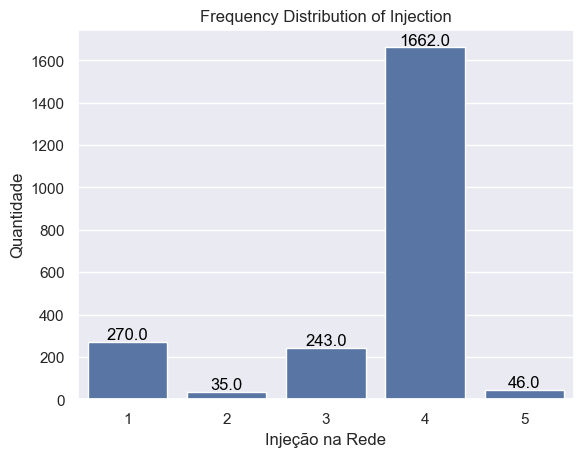

In [157]:
injecao_count = df3['Injeção na rede (kWh)'].value_counts()
sns.set(style='darkgrid')
barplot = sns.barplot(x=injecao_count.index, y=injecao_count.values)

for p in barplot.patches:
    barplot.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                     textcoords='offset points')

plt.title('Frequency Distribution of Injection')
plt.ylabel('Quantidade', fontsize=12)
plt.xlabel('Injeção na Rede', fontsize=12)
plt.show()

In [158]:
reverse_mapping_dict = {
    1: 'High',
    2: 'Low',
    3: 'Medium',
    4: 'None',
    5: 'Very High'
}

df_submission['Result'] = df_submission['Result'].replace(reverse_mapping_dict)
df_submission

,RowId,Result
0,1,None
1,2,None
2,3,None
3,4,None
4,5,None
...,...,...
2251,2252,None
2252,2253,None
2253,2254,None
2254,2255,None


In [159]:
# Guardar no ficheiro 'dummy_submission.csv'
df_submission.replace({None: 'None', np.nan: 'None'}, inplace=True)
df_submission.to_csv('./datasets/dummy_submission.csv', index=False)